### Homework01 - Classification task (part 2 )

student name : Daniele Mellino <br>
student id : 2013373<br>
Course: Neural Network and Deep Learning <br>
Professor: Testolin Alberto<br>

In [2]:
#libraries
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data
from torch.utils.data import Dataset, DataLoader,SubsetRandomSampler
from torch.nn import functional as F
import torchvision
from torchvision import transforms
import copy

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

In [3]:
train_dataset = torchvision.datasets.FashionMNIST('classifier_data', train=True, download=True)
test_dataset  = torchvision.datasets.FashionMNIST('classifier_data', train=False, download=True)


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting classifier_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to classifier_data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting classifier_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to classifier_data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting classifier_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to classifier_data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting classifier_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to classifier_data/FashionMNIST/raw



Sample Number: 12 
 Label :5 
 Image :


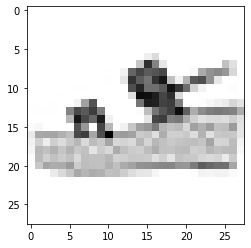

Number of objects: 10
Minimum pixel value : 0
Maximum pixel value : 255
-----  TRAIN NORMALIZATION VALUES  -----
Mean: 0.2860
Standard Deviation: 0.3530


In [4]:
print(f"Sample Number: {12}","\n",
      f"Label :{train_dataset[12][1]}","\n","Image :")
plt.imshow(train_dataset[12][0], cmap='Greys')
plt.show()

print("Number of objects:", (np.unique(train_dataset.targets).shape[0] ) )

min_px_value = train_dataset.data[0].min()
print(f"Minimum pixel value : {min_px_value}")
max_px_value = train_dataset.data[0].max()
print(f"Maximum pixel value : {max_px_value}")

# Data normalization
# Mean and std should be divided by 255 (maximum pixel value)
# because, after the ToTensor() transformation (see next step), images are normalized
# between 0 and 1.

train_mean = train_dataset.data.float().mean() / 255
train_std = train_dataset.data.float().std() / 255

print("-----  TRAIN NORMALIZATION VALUES  -----")
print(f"Mean: {train_mean:.4f}")
print(f"Standard Deviation: {train_std:.4f}")

In [5]:
# Compositions of transformations
train_transforms = torchvision.transforms.Compose([
                                                   torchvision.transforms.ToTensor(), # values are normalized between 0 and 1
                                                   torchvision.transforms.Normalize(train_mean, train_std)
])

test_transforms = torchvision.transforms.Compose([
                                                  torchvision.transforms.ToTensor(),
                                                  torchvision.transforms.Normalize(train_mean, train_std)
])

#test_dataset  = torchvision.datasets.FashionMNIST('classifier_data', train=False, download=True, transform=test_transforms)

# Set the train and test transform
train_dataset.transform = train_transforms
test_dataset.transform = test_transforms

In [6]:
def create_validation_set(train_data, train_percentage, test_transforms):
    
  # Split train data into train and validation sets
  # (train_percentage of training set will be used as validation set)
  num_train_examples = int(len(train_data) * train_percentage)
  num_valid_examples = len(train_data) - num_train_examples

  # Create 'Subset' objects
  train_data, valid_data = Data.random_split(train_data, [num_train_examples, num_valid_examples])

  print(f"Number training examples: {len(train_data)}")
  print(f"Number validation examples: {len(valid_data)}")

  # Apply test transformations to the validation set
  valid_data = copy.deepcopy(valid_data) # If we change train transformations, this won't affect the validation set
  valid_data.dataset.transform = test_transforms

  return valid_data

In [7]:
valid_dataset = create_validation_set(train_dataset, 0.8, test_transforms)

Number training examples: 48000
Number validation examples: 12000


#### early stopping class

In [8]:
class EarlyStopping():
    """
    Early stopping to stop the training when the loss does not improve after
    certain epochs.
    """
    def __init__(self, patience=5, min_delta=0):
        """
        :param patience: how many epochs to wait before stopping when loss is
               not improving
        :param min_delta: minimum difference between new loss and old loss for
               new loss to be considered as an improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            # reset counter if validation loss improves
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

### CNN 

In [102]:
class CNN2d(nn.Module):
    def __init__(self,n_feat, dp1D=0,dp2D=0, Nf = 100) :
        super(CNN2d,self).__init__()
        self.conv1 = nn.Conv2d(1, n_feat, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_feat, 2*n_feat, kernel_size=5) 
        self.pool1 = nn.MaxPool2d(2,2)
        self.drop1 = nn.Dropout2d(p=dp1D)
        self.drop2 = nn.Dropout2d(p=dp2D)
        self.fc1 = nn.Linear(in_features=n_feat*50, out_features=Nf)
        self.fc2 = nn.Linear(in_features=Nf, out_features=10 )


    def forward(self, x):
        
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = self.drop2(x)
        x = x.view(x.size(0), -1) # reshaping necessary for linear layer
        x = F.relu(self.fc1(x))
        x = self.drop1(x)
        x = self.fc2(x)
        return x

    def train_step(self, train_loader, optimizer, loss_fn, device):
        """
        basic training step
        """
        train_loss= []
        self.train() 
        for sample_batched in train_loader:
            x_batch,label_batch= sample_batched[0].to(device),sample_batched[1].to(device) # Move data to device 
            out = self.forward(x_batch) # Forward pass
            loss = loss_fn(out, label_batch) # Compute loss
            
            # Backpropagation
            self.zero_grad()
            loss.backward()
            
            optimizer.step() # Update the weights
            
            # Save training loss for this batch
            loss_batch = loss.detach().cpu().numpy()
            train_loss.append(loss_batch)
        return np.mean(train_loss)


    def validation_step(self, val_loader, loss_fn, device):
        """
        basic validation step
        """
        val_loss = []
        self.eval() 
        with torch.no_grad(): # Disable gradient tracking
            for sample_batched in val_loader:
                x_batch,label_batch = sample_batched[0].to(device),sample_batched[1].to(device) # Move data to device
                out = self.forward(x_batch) # Forward pass
                loss = loss_fn(out, label_batch) # Compute loss
                # Save validation loss for this batch
                loss_batch = loss.detach().cpu().numpy()
                val_loss.append(loss_batch)
        return np.mean(val_loss)

    def fit(self, train_loader, val_loader, optimizer, loss_fn, params):
        """
        function fit to train the model, it takes the Net, the train and validation 
        loaders, the optimizer and the loss function. 

        params : dictionary of parameters
        """
        early_stopping = EarlyStopping(params['patience'])
        train_loss_log = []
        val_loss_log = []
        for epoch in range( params['num_epochs']): #tqdm is just for displaying the progress bars
            ### TRAIN
            train_loss = self.train_step(train_loader, optimizer, loss_fn,  params['device'])
            ### VALIDATION
            val_loss = self.validation_step(val_loader, loss_fn,  params['device'])

            #early stopping
            early_stopping(val_loss)
            if early_stopping.early_stop:
                break

            # Save average train loss
            train_loss_log.append(train_loss)
            # Save average validation loss
            val_loss_log.append(val_loss)
            print(f"End_epoch number : {len(val_loss_log)}, train _loss is : {train_loss}, val_loss is {val_loss}" )
            
        return train_loss_log, val_loss_log


    def predict(self, dataloader, device):
        '''
        function that return the array of prediction, it take in input the device and the dataloader
        '''
        self.eval()
        pred = []
        with torch.no_grad(): # Disable gradient tracking
            for sample_batched in dataloader:
                # Move data to device
                x_batch = sample_batched[0].to(device)
                # Forward pass
                out = self.forward(x_batch)
                out = out.cpu().numpy()
                pred.append(out)
        return np.array( pred )
                
    def test(self, test_loader, device, loss_fn):
        """
        function used to get the test_loss and the accuracy
        """
        test_loss = []
        outs=[]
        labs=[]

        self.eval() # Evaluation mode (e.g. disable dropout)
        with torch.no_grad(): # Disable gradient tracking
            for sample_batched in test_loader:
                x_batch,label_batch= sample_batched[0].to(device),sample_batched[1].to(device) # Move data to device  #[0]
                out = self.forward(x_batch) # Forward pass
                loss = loss_fn(out, label_batch)# Compute the loss
                # Save validation loss and a for this batch
                out = out.cpu().numpy().argmax()
                outs.append(out)
                loss_batch = loss.detach().cpu().numpy()
                labs.append(sample_batched[1].squeeze().tolist())
                test_loss.append( loss_batch.mean() )

        p = np.array([ outs[i]-labs[i] for i in range(len(test_loader.dataset))])
        wrong = len(p[p!=0])/len(test_loader.dataset)
        return np.array(test_loss).mean(), 1.0-wrong
    
    def save(self, path):
        torch.save(self.state_dict(), path)
        
    def load(self, path):
        self.load_state_dict( torch.load(path) )
        
    def restart(self):
        self.__init__()
    

In [15]:
! pip install optuna mlflow

### Random search with pruning

In [16]:

import optuna
import mlflow

from mlflow import pytorch

In [17]:
# Obtain hyperparameters for this trial
def suggest_hyperparameters(trial):
    # Obtain the learning rate on a logarithmic scale
    lr = trial.suggest_float("lr", 1e-4, 5e-3, log=True)
    # Obtain the dropout ratio in a range from 0.0 to 0.9 with step size 0.1
    dropout1 = trial.suggest_float("dropout1", 0.0, 0.3, step=0.05)
    dropout2 = trial.suggest_float("dropout2", 0.0, 0.3, step=0.05)

    # Obtain the optimizer to use by name
    optimizer_name = trial.suggest_categorical("optimizer_name", ["Adam", "sgd"])
    n_feat = trial.suggest_int('n_feat', 3, 11, step=1)
    #obtain the regularization 
    rg = trial.suggest_float("regularizer", 0.0, 0.25, step=0.05)
    #obtain the number of final nodes
    Nf =  trial.suggest_int('n_nodes', 200, 500, step=50)
    print(f"Suggested hyperparameters: \n{pformat(trial.params)}")
    return lr, dropout1, dropout2, optimizer_name, n_feat, rg, Nf 

In [18]:

# Define the loss function
loss_fn = nn.CrossEntropyLoss()
num_epochs=10

def objective(trial):
    print("\n********************************\n")
    best_val_loss = float('Inf')
    
    # Start a new mlflow run
    with mlflow.start_run():
        # Get hyperparameter suggestions created by optuna and log them as params using mlflow
        lr, dp1, dp2, optimizer_name, n_feat, rg, Nf = suggest_hyperparameters(trial)
        mlflow.log_params(trial.params)

        # Use CUDA if GPU is available and log device as param using mlflow
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        mlflow.log_param("device", device)

        # Initialize network
        model = CNN2d(n_feat,dp1,dp2,Nf).to(device)

        # Pick an optimizer based on optuna's parameter suggestion
        if optimizer_name == "Adam":
            optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=rg)
        if optimizer_name == "sgd":
            optimizer = optim.SGD(model.parameters(), lr=lr,momentum=0.9, weight_decay= rg)
        
        # Get DataLoaders and validation set
        train_loader = DataLoader(train_dataset, batch_size=1000, shuffle=True,)             # change here the train / test set
        val_loader = DataLoader(valid_dataset, batch_size=1000,shuffle=False)  #


        # Network training & validation loop
        for epoch in range(0, num_epochs):
            avg_train_loss = model.train_step(train_loader, optimizer, loss_fn,  device)
            avg_val_loss = model.validation_step(val_loader, loss_fn,  device)
            if avg_val_loss <= best_val_loss:
                best_val_loss = avg_val_loss

            # Log average train and validation set loss metrics for the current epoch using mlflow
            mlflow.log_metric("avg_train_losses", avg_train_loss, step=epoch)
            mlflow.log_metric("avg_val_loss", avg_val_loss, step=epoch)
            
            #report intermediate obj values
            trial.report(avg_val_loss, step=epoch) 

            if trial.should_prune():
                raise optuna.TrialPruned()

            print(f"### EPOCH {epoch} val loss is: {avg_val_loss}; train loss is : {avg_train_loss}"  )
            
    # Return the best validation loss achieved by the network.
    # This is needed as Optuna needs to know how the suggested hyperparameters are influencing the network loss.
    return best_val_loss

    ##here one can try to maximize the accuracy instead !!!!!!!

In [19]:
from pprint import pformat
# Create the optuna study which shares the experiment name, this will be a random search
study = optuna.create_study(study_name="pytorch-mlflow-optuna", direction="minimize",sampler=optuna.samplers.RandomSampler(),
                            pruner=optuna.pruners.MedianPruner(n_startup_trials=3 ,n_warmup_steps=3))


study.optimize(objective, n_trials=100)  #    change number of trials

# Print optuna study statistics
print("\n++++++++++++++++++++++++++++++++++\n")
print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))

print("Best trial:")
trial = study.best_trial

print("  Trial number: ", trial.number)
print("  Loss (trial value): ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-02-05 00:21:49,408] A new study created in memory with name: pytorch-mlflow-optuna



********************************

Suggested hyperparameters: 
{'dropout1': 0.25,
 'dropout2': 0.2,
 'lr': 0.002723325494277519,
 'n_feat': 11,
 'n_nodes': 300,
 'optimizer_name': 'Adam',
 'regularizer': 0.15000000000000002}
### EPOCH 0 val loss is: 0.8970702290534973; train loss is : 1.300258994102478
### EPOCH 1 val loss is: 0.8696632385253906; train loss is : 0.9194978475570679
### EPOCH 2 val loss is: 0.8496038913726807; train loss is : 0.8909668326377869
### EPOCH 3 val loss is: 0.8636582493782043; train loss is : 0.8881586194038391
### EPOCH 4 val loss is: 0.8388506770133972; train loss is : 0.87586510181427
### EPOCH 5 val loss is: 0.8379420638084412; train loss is : 0.8774849772453308
### EPOCH 6 val loss is: 0.8317728042602539; train loss is : 0.8707910180091858
### EPOCH 7 val loss is: 0.8350028991699219; train loss is : 0.8696509599685669
### EPOCH 8 val loss is: 0.8272399306297302; train loss is : 0.8619144558906555


[I 2022-02-05 00:24:44,544] Trial 0 finished with value: 0.8272399306297302 and parameters: {'lr': 0.002723325494277519, 'dropout1': 0.25, 'dropout2': 0.2, 'optimizer_name': 'Adam', 'n_feat': 11, 'regularizer': 0.15000000000000002, 'n_nodes': 300}. Best is trial 0 with value: 0.8272399306297302.


### EPOCH 9 val loss is: 0.8350279927253723; train loss is : 0.8657466769218445

********************************

Suggested hyperparameters: 
{'dropout1': 0.0,
 'dropout2': 0.3,
 'lr': 0.0009600839395010844,
 'n_feat': 5,
 'n_nodes': 400,
 'optimizer_name': 'sgd',
 'regularizer': 0.05}
### EPOCH 0 val loss is: 2.2758307456970215; train loss is : 2.287885904312134
### EPOCH 1 val loss is: 2.2464094161987305; train loss is : 2.264524221420288
### EPOCH 2 val loss is: 2.195115327835083; train loss is : 2.229456663131714
### EPOCH 3 val loss is: 2.082049608230591; train loss is : 2.160435199737549
### EPOCH 4 val loss is: 1.796345829963684; train loss is : 1.9921622276306152
### EPOCH 5 val loss is: 1.321022868156433; train loss is : 1.631292462348938
### EPOCH 6 val loss is: 1.0236849784851074; train loss is : 1.2484251260757446
### EPOCH 7 val loss is: 0.8890816569328308; train loss is : 1.0377109050750732
### EPOCH 8 val loss is: 0.8168333172798157; train loss is : 0.930343508720398


[I 2022-02-05 00:27:12,048] Trial 1 finished with value: 0.7711718678474426 and parameters: {'lr': 0.0009600839395010844, 'dropout1': 0.0, 'dropout2': 0.3, 'optimizer_name': 'sgd', 'n_feat': 5, 'regularizer': 0.05, 'n_nodes': 400}. Best is trial 1 with value: 0.7711718678474426.


### EPOCH 9 val loss is: 0.7711718678474426; train loss is : 0.8710032105445862

********************************

Suggested hyperparameters: 
{'dropout1': 0.2,
 'dropout2': 0.25,
 'lr': 0.003478781353761463,
 'n_feat': 8,
 'n_nodes': 450,
 'optimizer_name': 'sgd',
 'regularizer': 0.25}
### EPOCH 0 val loss is: 2.241029977798462; train loss is : 2.2693073749542236
### EPOCH 1 val loss is: 2.1626315116882324; train loss is : 2.215895891189575
### EPOCH 2 val loss is: 1.5340337753295898; train loss is : 1.9573479890823364
### EPOCH 3 val loss is: 1.174244999885559; train loss is : 1.3147014379501343
### EPOCH 4 val loss is: 1.1270434856414795; train loss is : 1.182955265045166
### EPOCH 5 val loss is: 1.1016569137573242; train loss is : 1.1453324556350708
### EPOCH 6 val loss is: 1.0729455947875977; train loss is : 1.1170912981033325
### EPOCH 7 val loss is: 1.0599241256713867; train loss is : 1.1006247997283936
### EPOCH 8 val loss is: 1.0562105178833008; train loss is : 1.0869752168655

[I 2022-02-05 00:29:43,261] Trial 2 finished with value: 1.0457404851913452 and parameters: {'lr': 0.003478781353761463, 'dropout1': 0.2, 'dropout2': 0.25, 'optimizer_name': 'sgd', 'n_feat': 8, 'regularizer': 0.25, 'n_nodes': 450}. Best is trial 1 with value: 0.7711718678474426.


### EPOCH 9 val loss is: 1.0457404851913452; train loss is : 1.0807701349258423

********************************

Suggested hyperparameters: 
{'dropout1': 0.3,
 'dropout2': 0.1,
 'lr': 0.000364779788182339,
 'n_feat': 8,
 'n_nodes': 200,
 'optimizer_name': 'Adam',
 'regularizer': 0.2}
### EPOCH 0 val loss is: 2.143188238143921; train loss is : 2.2531206607818604
### EPOCH 1 val loss is: 1.2193622589111328; train loss is : 1.652626633644104
### EPOCH 2 val loss is: 1.0901494026184082; train loss is : 1.175504446029663
### EPOCH 3 val loss is: 1.013555645942688; train loss is : 1.0840764045715332
### EPOCH 4 val loss is: 0.982343852519989; train loss is : 1.0295021533966064
### EPOCH 5 val loss is: 0.9602412581443787; train loss is : 1.0014599561691284
### EPOCH 6 val loss is: 0.9567107558250427; train loss is : 0.9870765805244446


[I 2022-02-05 00:31:43,702] Trial 3 pruned. 



********************************

Suggested hyperparameters: 
{'dropout1': 0.3,
 'dropout2': 0.25,
 'lr': 0.002577470050941039,
 'n_feat': 5,
 'n_nodes': 250,
 'optimizer_name': 'Adam',
 'regularizer': 0.15000000000000002}
### EPOCH 0 val loss is: 1.025603175163269; train loss is : 1.4511895179748535
### EPOCH 1 val loss is: 0.9319978356361389; train loss is : 1.0372103452682495
### EPOCH 2 val loss is: 0.8964840769767761; train loss is : 0.969344973564148
### EPOCH 3 val loss is: 0.9378295540809631; train loss is : 0.9612646102905273
### EPOCH 4 val loss is: 0.8777186274528503; train loss is : 0.9605596661567688
### EPOCH 5 val loss is: 0.881040632724762; train loss is : 0.949263870716095
### EPOCH 6 val loss is: 0.875838577747345; train loss is : 0.9452507495880127
### EPOCH 7 val loss is: 0.8904700875282288; train loss is : 0.9367754459381104


[I 2022-02-05 00:33:55,525] Trial 4 pruned. 



********************************

Suggested hyperparameters: 
{'dropout1': 0.15000000000000002,
 'dropout2': 0.0,
 'lr': 0.0022473124835672926,
 'n_feat': 4,
 'n_nodes': 350,
 'optimizer_name': 'sgd',
 'regularizer': 0.0}
### EPOCH 0 val loss is: 2.1967031955718994; train loss is : 2.266663074493408
### EPOCH 1 val loss is: 1.1724231243133545; train loss is : 1.8336846828460693
### EPOCH 2 val loss is: 0.8487178683280945; train loss is : 0.9959740042686462
### EPOCH 3 val loss is: 0.7639190554618835; train loss is : 0.8379932641983032
### EPOCH 4 val loss is: 0.7110833525657654; train loss is : 0.7688904404640198
### EPOCH 5 val loss is: 0.6720482707023621; train loss is : 0.7214779257774353
### EPOCH 6 val loss is: 0.6412466168403625; train loss is : 0.6868455410003662
### EPOCH 7 val loss is: 0.6111248135566711; train loss is : 0.654190182685852
### EPOCH 8 val loss is: 0.591359555721283; train loss is : 0.6300062537193298


[I 2022-02-05 00:36:21,097] Trial 5 finished with value: 0.575335681438446 and parameters: {'lr': 0.0022473124835672926, 'dropout1': 0.15000000000000002, 'dropout2': 0.0, 'optimizer_name': 'sgd', 'n_feat': 4, 'regularizer': 0.0, 'n_nodes': 350}. Best is trial 5 with value: 0.575335681438446.


### EPOCH 9 val loss is: 0.575335681438446; train loss is : 0.6083866357803345

********************************

Suggested hyperparameters: 
{'dropout1': 0.1,
 'dropout2': 0.1,
 'lr': 0.0002578083369504958,
 'n_feat': 11,
 'n_nodes': 400,
 'optimizer_name': 'Adam',
 'regularizer': 0.0}
### EPOCH 0 val loss is: 0.7886804938316345; train loss is : 1.3928675651550293
### EPOCH 1 val loss is: 0.6207607984542847; train loss is : 0.7243956923484802
### EPOCH 2 val loss is: 0.5372262597084045; train loss is : 0.6059949398040771
### EPOCH 3 val loss is: 0.48079395294189453; train loss is : 0.5370909571647644
### EPOCH 4 val loss is: 0.44378694891929626; train loss is : 0.4913407862186432
### EPOCH 5 val loss is: 0.41993260383605957; train loss is : 0.4577353596687317
### EPOCH 6 val loss is: 0.39637041091918945; train loss is : 0.43280646204948425
### EPOCH 7 val loss is: 0.38013240694999695; train loss is : 0.41247257590293884
### EPOCH 8 val loss is: 0.3630506098270416; train loss is : 0.39

[I 2022-02-05 00:38:55,236] Trial 6 finished with value: 0.3485323190689087 and parameters: {'lr': 0.0002578083369504958, 'dropout1': 0.1, 'dropout2': 0.1, 'optimizer_name': 'Adam', 'n_feat': 11, 'regularizer': 0.0, 'n_nodes': 400}. Best is trial 6 with value: 0.3485323190689087.


### EPOCH 9 val loss is: 0.3485323190689087; train loss is : 0.3833398222923279

********************************

Suggested hyperparameters: 
{'dropout1': 0.25,
 'dropout2': 0.1,
 'lr': 0.003626980282257774,
 'n_feat': 9,
 'n_nodes': 450,
 'optimizer_name': 'Adam',
 'regularizer': 0.2}
### EPOCH 0 val loss is: 1.0405434370040894; train loss is : 1.3729689121246338
### EPOCH 1 val loss is: 0.9649214744567871; train loss is : 1.0467921495437622
### EPOCH 2 val loss is: 0.9502978324890137; train loss is : 1.0057028532028198


[I 2022-02-05 00:39:56,212] Trial 7 pruned. 



********************************

Suggested hyperparameters: 
{'dropout1': 0.1,
 'dropout2': 0.2,
 'lr': 0.00012280438791670615,
 'n_feat': 3,
 'n_nodes': 250,
 'optimizer_name': 'Adam',
 'regularizer': 0.25}
### EPOCH 0 val loss is: 2.293562889099121; train loss is : 2.296220064163208
### EPOCH 1 val loss is: 2.2908992767333984; train loss is : 2.292377233505249
### EPOCH 2 val loss is: 2.2887725830078125; train loss is : 2.29020619392395


[I 2022-02-05 00:40:53,548] Trial 8 pruned. 



********************************

Suggested hyperparameters: 
{'dropout1': 0.3,
 'dropout2': 0.15000000000000002,
 'lr': 0.001671000884326215,
 'n_feat': 6,
 'n_nodes': 300,
 'optimizer_name': 'Adam',
 'regularizer': 0.05}
### EPOCH 0 val loss is: 0.710591733455658; train loss is : 1.2013664245605469
### EPOCH 1 val loss is: 0.6721217632293701; train loss is : 0.7206918001174927
### EPOCH 2 val loss is: 0.6094260811805725; train loss is : 0.667100727558136
### EPOCH 3 val loss is: 0.5756176114082336; train loss is : 0.6468759179115295
### EPOCH 4 val loss is: 0.5773058533668518; train loss is : 0.6247528791427612
### EPOCH 5 val loss is: 0.5606936812400818; train loss is : 0.6122604012489319
### EPOCH 6 val loss is: 0.5508766174316406; train loss is : 0.5988485813140869
### EPOCH 7 val loss is: 0.5618388652801514; train loss is : 0.5945460200309753
### EPOCH 8 val loss is: 0.5327511429786682; train loss is : 0.5924555063247681


[I 2022-02-05 00:43:21,310] Trial 9 finished with value: 0.5303265452384949 and parameters: {'lr': 0.001671000884326215, 'dropout1': 0.3, 'dropout2': 0.15000000000000002, 'optimizer_name': 'Adam', 'n_feat': 6, 'regularizer': 0.05, 'n_nodes': 300}. Best is trial 6 with value: 0.3485323190689087.


### EPOCH 9 val loss is: 0.5303265452384949; train loss is : 0.5799732208251953

********************************

Suggested hyperparameters: 
{'dropout1': 0.15000000000000002,
 'dropout2': 0.05,
 'lr': 0.0033579072165254046,
 'n_feat': 3,
 'n_nodes': 200,
 'optimizer_name': 'Adam',
 'regularizer': 0.25}
### EPOCH 0 val loss is: 2.3026182651519775; train loss is : 2.301142930984497
### EPOCH 1 val loss is: 2.302581310272217; train loss is : 2.3026154041290283
### EPOCH 2 val loss is: 2.3026230335235596; train loss is : 2.3026278018951416


[I 2022-02-05 00:44:19,597] Trial 10 pruned. 



********************************

Suggested hyperparameters: 
{'dropout1': 0.0,
 'dropout2': 0.3,
 'lr': 0.00013913145338038005,
 'n_feat': 6,
 'n_nodes': 250,
 'optimizer_name': 'sgd',
 'regularizer': 0.0}
### EPOCH 0 val loss is: 2.288351535797119; train loss is : 2.2946178913116455
### EPOCH 1 val loss is: 2.2807750701904297; train loss is : 2.287490129470825
### EPOCH 2 val loss is: 2.2728164196014404; train loss is : 2.2804834842681885


[I 2022-02-05 00:45:18,735] Trial 11 pruned. 



********************************

Suggested hyperparameters: 
{'dropout1': 0.25,
 'dropout2': 0.0,
 'lr': 0.000520901518912739,
 'n_feat': 5,
 'n_nodes': 450,
 'optimizer_name': 'Adam',
 'regularizer': 0.25}
### EPOCH 0 val loss is: 2.2581591606140137; train loss is : 2.2777528762817383
### EPOCH 1 val loss is: 1.8427284955978394; train loss is : 2.1406900882720947
### EPOCH 2 val loss is: 1.2965213060379028; train loss is : 1.5551869869232178


[I 2022-02-05 00:46:17,890] Trial 12 pruned. 



********************************

Suggested hyperparameters: 
{'dropout1': 0.05,
 'dropout2': 0.3,
 'lr': 0.0010844379055942551,
 'n_feat': 11,
 'n_nodes': 250,
 'optimizer_name': 'Adam',
 'regularizer': 0.15000000000000002}
### EPOCH 0 val loss is: 1.0498334169387817; train loss is : 1.6515227556228638
### EPOCH 1 val loss is: 0.9131630063056946; train loss is : 0.9944400787353516
### EPOCH 2 val loss is: 0.8847396373748779; train loss is : 0.9392568469047546


[I 2022-02-05 00:47:21,273] Trial 13 pruned. 



********************************

Suggested hyperparameters: 
{'dropout1': 0.2,
 'dropout2': 0.3,
 'lr': 0.00020101476357246606,
 'n_feat': 6,
 'n_nodes': 500,
 'optimizer_name': 'sgd',
 'regularizer': 0.1}
### EPOCH 0 val loss is: 2.301534414291382; train loss is : 2.306670904159546
### EPOCH 1 val loss is: 2.2923715114593506; train loss is : 2.2980573177337646
### EPOCH 2 val loss is: 2.2838380336761475; train loss is : 2.2893834114074707


[I 2022-02-05 00:48:22,130] Trial 14 pruned. 



********************************

Suggested hyperparameters: 
{'dropout1': 0.15000000000000002,
 'dropout2': 0.2,
 'lr': 0.0013443641833918872,
 'n_feat': 7,
 'n_nodes': 400,
 'optimizer_name': 'Adam',
 'regularizer': 0.2}
### EPOCH 0 val loss is: 1.1117968559265137; train loss is : 1.8085664510726929
### EPOCH 1 val loss is: 0.9493544697761536; train loss is : 1.0358383655548096
### EPOCH 2 val loss is: 0.9348180294036865; train loss is : 0.9773534536361694


[I 2022-02-05 00:49:23,194] Trial 15 pruned. 



********************************

Suggested hyperparameters: 
{'dropout1': 0.25,
 'dropout2': 0.25,
 'lr': 0.001324161150123406,
 'n_feat': 5,
 'n_nodes': 450,
 'optimizer_name': 'Adam',
 'regularizer': 0.0}
### EPOCH 0 val loss is: 0.6124464273452759; train loss is : 1.0588067770004272
### EPOCH 1 val loss is: 0.48476341366767883; train loss is : 0.6052960157394409
### EPOCH 2 val loss is: 0.42247167229652405; train loss is : 0.5100613236427307
### EPOCH 3 val loss is: 0.3951682150363922; train loss is : 0.4580591022968292
### EPOCH 4 val loss is: 0.3615431487560272; train loss is : 0.42599084973335266
### EPOCH 5 val loss is: 0.3305417001247406; train loss is : 0.3985458314418793
### EPOCH 6 val loss is: 0.31588274240493774; train loss is : 0.3781846761703491
### EPOCH 7 val loss is: 0.3053447902202606; train loss is : 0.3636544644832611
### EPOCH 8 val loss is: 0.29740583896636963; train loss is : 0.3495137393474579


[I 2022-02-05 00:51:53,546] Trial 16 finished with value: 0.2917865812778473 and parameters: {'lr': 0.001324161150123406, 'dropout1': 0.25, 'dropout2': 0.25, 'optimizer_name': 'Adam', 'n_feat': 5, 'regularizer': 0.0, 'n_nodes': 450}. Best is trial 16 with value: 0.2917865812778473.


### EPOCH 9 val loss is: 0.2917865812778473; train loss is : 0.34082889556884766

********************************

Suggested hyperparameters: 
{'dropout1': 0.1,
 'dropout2': 0.0,
 'lr': 0.0004851684141358531,
 'n_feat': 11,
 'n_nodes': 350,
 'optimizer_name': 'sgd',
 'regularizer': 0.0}
### EPOCH 0 val loss is: 2.2048146724700928; train loss is : 2.265068769454956
### EPOCH 1 val loss is: 2.010529041290283; train loss is : 2.12203311920166
### EPOCH 2 val loss is: 1.6136560440063477; train loss is : 1.8359638452529907


[I 2022-02-05 00:52:55,969] Trial 17 pruned. 



********************************

Suggested hyperparameters: 
{'dropout1': 0.3,
 'dropout2': 0.0,
 'lr': 0.00026628645333196855,
 'n_feat': 3,
 'n_nodes': 450,
 'optimizer_name': 'sgd',
 'regularizer': 0.25}
### EPOCH 0 val loss is: 2.292907476425171; train loss is : 2.3005034923553467
### EPOCH 1 val loss is: 2.2837107181549072; train loss is : 2.2892117500305176
### EPOCH 2 val loss is: 2.2759618759155273; train loss is : 2.280606508255005


[I 2022-02-05 00:53:54,159] Trial 18 pruned. 



********************************

Suggested hyperparameters: 
{'dropout1': 0.2,
 'dropout2': 0.1,
 'lr': 0.00017441975302246167,
 'n_feat': 8,
 'n_nodes': 200,
 'optimizer_name': 'sgd',
 'regularizer': 0.05}
### EPOCH 0 val loss is: 2.3040482997894287; train loss is : 2.3088128566741943
### EPOCH 1 val loss is: 2.296008586883545; train loss is : 2.3009912967681885
### EPOCH 2 val loss is: 2.2886099815368652; train loss is : 2.293410301208496


[I 2022-02-05 00:54:54,386] Trial 19 pruned. 



********************************

Suggested hyperparameters: 
{'dropout1': 0.25,
 'dropout2': 0.05,
 'lr': 0.0005751279609038978,
 'n_feat': 5,
 'n_nodes': 500,
 'optimizer_name': 'Adam',
 'regularizer': 0.0}
### EPOCH 0 val loss is: 0.735576868057251; train loss is : 1.3282837867736816
### EPOCH 1 val loss is: 0.5722748041152954; train loss is : 0.678280770778656
### EPOCH 2 val loss is: 0.5010924935340881; train loss is : 0.5717507004737854
### EPOCH 3 val loss is: 0.4588797986507416; train loss is : 0.5137484073638916
### EPOCH 4 val loss is: 0.4300529956817627; train loss is : 0.475666880607605
### EPOCH 5 val loss is: 0.4037211239337921; train loss is : 0.44963371753692627
### EPOCH 6 val loss is: 0.38573336601257324; train loss is : 0.4226827323436737
### EPOCH 7 val loss is: 0.3679794371128082; train loss is : 0.4053778052330017
### EPOCH 8 val loss is: 0.35999083518981934; train loss is : 0.3910068869590759


[I 2022-02-05 00:57:25,613] Trial 20 finished with value: 0.34255480766296387 and parameters: {'lr': 0.0005751279609038978, 'dropout1': 0.25, 'dropout2': 0.05, 'optimizer_name': 'Adam', 'n_feat': 5, 'regularizer': 0.0, 'n_nodes': 500}. Best is trial 16 with value: 0.2917865812778473.


### EPOCH 9 val loss is: 0.34255480766296387; train loss is : 0.37557774782180786

********************************

Suggested hyperparameters: 
{'dropout1': 0.3,
 'dropout2': 0.3,
 'lr': 0.0006203052013006335,
 'n_feat': 3,
 'n_nodes': 450,
 'optimizer_name': 'Adam',
 'regularizer': 0.2}
### EPOCH 0 val loss is: 1.6785451173782349; train loss is : 2.127675771713257
### EPOCH 1 val loss is: 1.1493765115737915; train loss is : 1.4073169231414795
### EPOCH 2 val loss is: 1.013757348060608; train loss is : 1.1420177221298218


[I 2022-02-05 00:58:24,213] Trial 21 pruned. 



********************************

Suggested hyperparameters: 
{'dropout1': 0.0,
 'dropout2': 0.2,
 'lr': 0.000888000024563023,
 'n_feat': 9,
 'n_nodes': 350,
 'optimizer_name': 'sgd',
 'regularizer': 0.05}
### EPOCH 0 val loss is: 2.275597333908081; train loss is : 2.2915780544281006
### EPOCH 1 val loss is: 2.231903314590454; train loss is : 2.2587220668792725
### EPOCH 2 val loss is: 2.1330740451812744; train loss is : 2.197563409805298


[I 2022-02-05 00:59:25,592] Trial 22 pruned. 



********************************

Suggested hyperparameters: 
{'dropout1': 0.15000000000000002,
 'dropout2': 0.2,
 'lr': 0.0005305039433058243,
 'n_feat': 9,
 'n_nodes': 300,
 'optimizer_name': 'sgd',
 'regularizer': 0.2}
### EPOCH 0 val loss is: 2.2917377948760986; train loss is : 2.297663450241089
### EPOCH 1 val loss is: 2.2842276096343994; train loss is : 2.2884862422943115
### EPOCH 2 val loss is: 2.2789742946624756; train loss is : 2.2826597690582275


[I 2022-02-05 01:00:27,027] Trial 23 pruned. 



********************************

Suggested hyperparameters: 
{'dropout1': 0.3,
 'dropout2': 0.15000000000000002,
 'lr': 0.0004776451994072463,
 'n_feat': 3,
 'n_nodes': 350,
 'optimizer_name': 'Adam',
 'regularizer': 0.2}
### EPOCH 0 val loss is: 2.2555158138275146; train loss is : 2.2811942100524902
### EPOCH 1 val loss is: 1.7138214111328125; train loss is : 2.1023800373077393
### EPOCH 2 val loss is: 1.2038109302520752; train loss is : 1.4157211780548096


[I 2022-02-05 01:01:25,483] Trial 24 pruned. 



********************************

Suggested hyperparameters: 
{'dropout1': 0.1,
 'dropout2': 0.3,
 'lr': 0.00011113261438063559,
 'n_feat': 8,
 'n_nodes': 250,
 'optimizer_name': 'sgd',
 'regularizer': 0.2}
### EPOCH 0 val loss is: 2.301870107650757; train loss is : 2.3042237758636475
### EPOCH 1 val loss is: 2.2983338832855225; train loss is : 2.3005447387695312
### EPOCH 2 val loss is: 2.2953078746795654; train loss is : 2.2975258827209473


[I 2022-02-05 01:02:25,516] Trial 25 pruned. 



********************************

Suggested hyperparameters: 
{'dropout1': 0.1,
 'dropout2': 0.25,
 'lr': 0.002249598516605373,
 'n_feat': 10,
 'n_nodes': 250,
 'optimizer_name': 'Adam',
 'regularizer': 0.1}
### EPOCH 0 val loss is: 0.8177494406700134; train loss is : 1.0939055681228638
### EPOCH 1 val loss is: 0.7909225821495056; train loss is : 0.8216758966445923
### EPOCH 2 val loss is: 0.7531454563140869; train loss is : 0.7966770529747009


[I 2022-02-05 01:03:26,539] Trial 26 pruned. 



********************************

Suggested hyperparameters: 
{'dropout1': 0.15000000000000002,
 'dropout2': 0.25,
 'lr': 0.00040739879845398626,
 'n_feat': 4,
 'n_nodes': 200,
 'optimizer_name': 'Adam',
 'regularizer': 0.2}
### EPOCH 0 val loss is: 2.2673094272613525; train loss is : 2.2830755710601807
### EPOCH 1 val loss is: 1.9628705978393555; train loss is : 2.194261312484741
### EPOCH 2 val loss is: 1.2435091733932495; train loss is : 1.5476080179214478


[I 2022-02-05 01:04:24,979] Trial 27 pruned. 



********************************

Suggested hyperparameters: 
{'dropout1': 0.1,
 'dropout2': 0.05,
 'lr': 0.00017944144134822714,
 'n_feat': 11,
 'n_nodes': 400,
 'optimizer_name': 'Adam',
 'regularizer': 0.2}
### EPOCH 0 val loss is: 2.2392873764038086; train loss is : 2.274724006652832
### EPOCH 1 val loss is: 1.7880946397781372; train loss is : 2.093628168106079
### EPOCH 2 val loss is: 1.2103971242904663; train loss is : 1.4349309206008911


[I 2022-02-05 01:05:26,943] Trial 28 pruned. 



********************************

Suggested hyperparameters: 
{'dropout1': 0.1,
 'dropout2': 0.2,
 'lr': 0.0017851986319475004,
 'n_feat': 9,
 'n_nodes': 450,
 'optimizer_name': 'sgd',
 'regularizer': 0.2}
### EPOCH 0 val loss is: 2.273498773574829; train loss is : 2.2875075340270996
### EPOCH 1 val loss is: 2.261099100112915; train loss is : 2.2689144611358643
### EPOCH 2 val loss is: 2.2514984607696533; train loss is : 2.258734703063965


[I 2022-02-05 01:06:28,246] Trial 29 pruned. 



********************************

Suggested hyperparameters: 
{'dropout1': 0.3,
 'dropout2': 0.1,
 'lr': 0.002758298734238159,
 'n_feat': 4,
 'n_nodes': 500,
 'optimizer_name': 'Adam',
 'regularizer': 0.25}
### EPOCH 0 val loss is: 1.1875306367874146; train loss is : 1.6764277219772339
### EPOCH 1 val loss is: 1.115667462348938; train loss is : 1.1733758449554443
### EPOCH 2 val loss is: 1.0841132402420044; train loss is : 1.1334757804870605


[I 2022-02-05 01:07:27,029] Trial 30 pruned. 



********************************

Suggested hyperparameters: 
{'dropout1': 0.0,
 'dropout2': 0.15000000000000002,
 'lr': 0.00038549808786389255,
 'n_feat': 8,
 'n_nodes': 400,
 'optimizer_name': 'Adam',
 'regularizer': 0.25}
### EPOCH 0 val loss is: 2.1703193187713623; train loss is : 2.2582929134368896
### EPOCH 1 val loss is: 1.2792426347732544; train loss is : 1.7118383646011353
### EPOCH 2 val loss is: 1.1652556657791138; train loss is : 1.2146263122558594


[I 2022-02-05 01:08:27,246] Trial 31 pruned. 



********************************

Suggested hyperparameters: 
{'dropout1': 0.2,
 'dropout2': 0.15000000000000002,
 'lr': 0.0029658758671468125,
 'n_feat': 7,
 'n_nodes': 250,
 'optimizer_name': 'Adam',
 'regularizer': 0.05}
### EPOCH 0 val loss is: 0.6693633198738098; train loss is : 1.0727336406707764
### EPOCH 1 val loss is: 0.6142244338989258; train loss is : 0.6940756440162659
### EPOCH 2 val loss is: 0.588131844997406; train loss is : 0.6339797377586365
### EPOCH 3 val loss is: 0.562390923500061; train loss is : 0.6126298904418945
### EPOCH 4 val loss is: 0.5494117736816406; train loss is : 0.6029682755470276
### EPOCH 5 val loss is: 0.5595663785934448; train loss is : 0.5930790305137634
### EPOCH 6 val loss is: 0.5422212481498718; train loss is : 0.590087890625
### EPOCH 7 val loss is: 0.5658069849014282; train loss is : 0.5874175429344177
### EPOCH 8 val loss is: 0.5658503174781799; train loss is : 0.5869846940040588


[I 2022-02-05 01:10:56,788] Trial 32 finished with value: 0.539339542388916 and parameters: {'lr': 0.0029658758671468125, 'dropout1': 0.2, 'dropout2': 0.15000000000000002, 'optimizer_name': 'Adam', 'n_feat': 7, 'regularizer': 0.05, 'n_nodes': 250}. Best is trial 16 with value: 0.2917865812778473.


### EPOCH 9 val loss is: 0.539339542388916; train loss is : 0.5843661427497864

********************************

Suggested hyperparameters: 
{'dropout1': 0.3,
 'dropout2': 0.05,
 'lr': 0.0023099768462050045,
 'n_feat': 8,
 'n_nodes': 400,
 'optimizer_name': 'Adam',
 'regularizer': 0.05}
### EPOCH 0 val loss is: 0.665378749370575; train loss is : 0.9944696426391602
### EPOCH 1 val loss is: 0.622484564781189; train loss is : 0.6855649948120117
### EPOCH 2 val loss is: 0.5991204380989075; train loss is : 0.6387348175048828


[I 2022-02-05 01:11:56,938] Trial 33 pruned. 



********************************

Suggested hyperparameters: 
{'dropout1': 0.25,
 'dropout2': 0.2,
 'lr': 0.0011959148029014653,
 'n_feat': 4,
 'n_nodes': 300,
 'optimizer_name': 'sgd',
 'regularizer': 0.25}
### EPOCH 0 val loss is: 2.2826015949249268; train loss is : 2.292938709259033
### EPOCH 1 val loss is: 2.273036003112793; train loss is : 2.279656171798706
### EPOCH 2 val loss is: 2.2609517574310303; train loss is : 2.269502878189087


[I 2022-02-05 01:12:55,383] Trial 34 pruned. 



********************************

Suggested hyperparameters: 
{'dropout1': 0.0,
 'dropout2': 0.1,
 'lr': 0.0012570274258341377,
 'n_feat': 3,
 'n_nodes': 200,
 'optimizer_name': 'sgd',
 'regularizer': 0.25}
### EPOCH 0 val loss is: 2.2971913814544678; train loss is : 2.303302526473999
### EPOCH 1 val loss is: 2.2945516109466553; train loss is : 2.2951197624206543
### EPOCH 2 val loss is: 2.2952487468719482; train loss is : 2.294635534286499


[I 2022-02-05 01:13:52,556] Trial 35 pruned. 



********************************

Suggested hyperparameters: 
{'dropout1': 0.25,
 'dropout2': 0.25,
 'lr': 0.0005232718116625716,
 'n_feat': 11,
 'n_nodes': 500,
 'optimizer_name': 'sgd',
 'regularizer': 0.1}
### EPOCH 0 val loss is: 2.2359654903411865; train loss is : 2.276322364807129
### EPOCH 1 val loss is: 2.145435333251953; train loss is : 2.2062385082244873
### EPOCH 2 val loss is: 1.9760289192199707; train loss is : 2.092074155807495


[I 2022-02-05 01:14:54,113] Trial 36 pruned. 



********************************

Suggested hyperparameters: 
{'dropout1': 0.1,
 'dropout2': 0.2,
 'lr': 0.0003504363803002087,
 'n_feat': 4,
 'n_nodes': 400,
 'optimizer_name': 'sgd',
 'regularizer': 0.15000000000000002}
### EPOCH 0 val loss is: 2.2964298725128174; train loss is : 2.3024744987487793
### EPOCH 1 val loss is: 2.2853281497955322; train loss is : 2.291292667388916
### EPOCH 2 val loss is: 2.274949312210083; train loss is : 2.2811076641082764


[I 2022-02-05 01:15:52,202] Trial 37 pruned. 



********************************

Suggested hyperparameters: 
{'dropout1': 0.05,
 'dropout2': 0.0,
 'lr': 0.0003533065629117266,
 'n_feat': 8,
 'n_nodes': 350,
 'optimizer_name': 'sgd',
 'regularizer': 0.1}
### EPOCH 0 val loss is: 2.27628755569458; train loss is : 2.287083625793457
### EPOCH 1 val loss is: 2.251579523086548; train loss is : 2.263796806335449
### EPOCH 2 val loss is: 2.2195470333099365; train loss is : 2.2359464168548584


[I 2022-02-05 01:16:51,672] Trial 38 pruned. 



********************************

Suggested hyperparameters: 
{'dropout1': 0.2,
 'dropout2': 0.25,
 'lr': 0.004215514706089433,
 'n_feat': 7,
 'n_nodes': 300,
 'optimizer_name': 'sgd',
 'regularizer': 0.2}
### EPOCH 0 val loss is: 2.045400381088257; train loss is : 2.220332384109497
### EPOCH 1 val loss is: 1.1064825057983398; train loss is : 1.5345171689987183
### EPOCH 2 val loss is: 1.0377625226974487; train loss is : 1.1274299621582031


[I 2022-02-05 01:17:50,177] Trial 39 pruned. 



********************************

Suggested hyperparameters: 
{'dropout1': 0.3,
 'dropout2': 0.05,
 'lr': 0.003848463225531802,
 'n_feat': 6,
 'n_nodes': 200,
 'optimizer_name': 'Adam',
 'regularizer': 0.2}
### EPOCH 0 val loss is: 1.102771282196045; train loss is : 1.8015055656433105
### EPOCH 1 val loss is: 0.9010198712348938; train loss is : 0.97396320104599
### EPOCH 2 val loss is: 0.8828502297401428; train loss is : 0.9307243824005127


[I 2022-02-05 01:18:47,793] Trial 40 pruned. 



********************************

Suggested hyperparameters: 
{'dropout1': 0.05,
 'dropout2': 0.3,
 'lr': 0.001483439183354937,
 'n_feat': 10,
 'n_nodes': 450,
 'optimizer_name': 'Adam',
 'regularizer': 0.25}
### EPOCH 0 val loss is: 1.103968620300293; train loss is : 1.6584856510162354
### EPOCH 1 val loss is: 1.0152323246002197; train loss is : 1.0562191009521484
### EPOCH 2 val loss is: 1.0183829069137573; train loss is : 1.030272364616394


[I 2022-02-05 01:19:48,222] Trial 41 pruned. 



********************************

Suggested hyperparameters: 
{'dropout1': 0.15000000000000002,
 'dropout2': 0.2,
 'lr': 0.001031295758172262,
 'n_feat': 6,
 'n_nodes': 400,
 'optimizer_name': 'Adam',
 'regularizer': 0.05}
### EPOCH 0 val loss is: 0.8026835322380066; train loss is : 1.270106554031372
### EPOCH 1 val loss is: 0.6995354294776917; train loss is : 0.7819575667381287
### EPOCH 2 val loss is: 0.6460738182067871; train loss is : 0.717270016670227


[I 2022-02-05 01:20:46,764] Trial 42 pruned. 



********************************

Suggested hyperparameters: 
{'dropout1': 0.15000000000000002,
 'dropout2': 0.2,
 'lr': 0.00011280662495399539,
 'n_feat': 9,
 'n_nodes': 500,
 'optimizer_name': 'Adam',
 'regularizer': 0.15000000000000002}
### EPOCH 0 val loss is: 2.162836790084839; train loss is : 2.2501907348632812
### EPOCH 1 val loss is: 1.5557461977005005; train loss is : 1.9347589015960693
### EPOCH 2 val loss is: 1.1394877433776855; train loss is : 1.3340072631835938


[I 2022-02-05 01:21:47,171] Trial 43 pruned. 



********************************

Suggested hyperparameters: 
{'dropout1': 0.05,
 'dropout2': 0.3,
 'lr': 0.0001510643763417439,
 'n_feat': 7,
 'n_nodes': 500,
 'optimizer_name': 'sgd',
 'regularizer': 0.05}
### EPOCH 0 val loss is: 2.3001620769500732; train loss is : 2.306352138519287
### EPOCH 1 val loss is: 2.2889797687530518; train loss is : 2.2958896160125732
### EPOCH 2 val loss is: 2.278531312942505; train loss is : 2.28572154045105


[I 2022-02-05 01:22:46,626] Trial 44 pruned. 



********************************

Suggested hyperparameters: 
{'dropout1': 0.1,
 'dropout2': 0.25,
 'lr': 0.0024901855466353206,
 'n_feat': 10,
 'n_nodes': 200,
 'optimizer_name': 'Adam',
 'regularizer': 0.2}
### EPOCH 0 val loss is: 0.9974918961524963; train loss is : 1.336205005645752
### EPOCH 1 val loss is: 0.9623433947563171; train loss is : 1.024601697921753
### EPOCH 2 val loss is: 0.9475058913230896; train loss is : 0.9950518012046814


[I 2022-02-05 01:23:47,415] Trial 45 pruned. 



********************************

Suggested hyperparameters: 
{'dropout1': 0.05,
 'dropout2': 0.3,
 'lr': 0.00011575959431047835,
 'n_feat': 9,
 'n_nodes': 300,
 'optimizer_name': 'sgd',
 'regularizer': 0.05}
### EPOCH 0 val loss is: 2.298863649368286; train loss is : 2.301997661590576
### EPOCH 1 val loss is: 2.2945241928100586; train loss is : 2.2982895374298096
### EPOCH 2 val loss is: 2.290419340133667; train loss is : 2.2943243980407715


[I 2022-02-05 01:24:47,672] Trial 46 pruned. 



********************************

Suggested hyperparameters: 
{'dropout1': 0.0,
 'dropout2': 0.25,
 'lr': 0.00037484950988145825,
 'n_feat': 7,
 'n_nodes': 450,
 'optimizer_name': 'Adam',
 'regularizer': 0.0}
### EPOCH 0 val loss is: 0.7062326073646545; train loss is : 1.360547423362732
### EPOCH 1 val loss is: 0.5553044676780701; train loss is : 0.6538336873054504
### EPOCH 2 val loss is: 0.4993133544921875; train loss is : 0.559086263179779
### EPOCH 3 val loss is: 0.45437073707580566; train loss is : 0.509090006351471
### EPOCH 4 val loss is: 0.4289805591106415; train loss is : 0.4759436547756195
### EPOCH 5 val loss is: 0.42077866196632385; train loss is : 0.4569464325904846
### EPOCH 6 val loss is: 0.3963894546031952; train loss is : 0.43978163599967957
### EPOCH 7 val loss is: 0.38754650950431824; train loss is : 0.42601272463798523
### EPOCH 8 val loss is: 0.3747728168964386; train loss is : 0.4161311686038971


[I 2022-02-05 01:27:15,278] Trial 47 finished with value: 0.37179088592529297 and parameters: {'lr': 0.00037484950988145825, 'dropout1': 0.0, 'dropout2': 0.25, 'optimizer_name': 'Adam', 'n_feat': 7, 'regularizer': 0.0, 'n_nodes': 450}. Best is trial 16 with value: 0.2917865812778473.


### EPOCH 9 val loss is: 0.37179088592529297; train loss is : 0.4080283045768738

********************************

Suggested hyperparameters: 
{'dropout1': 0.15000000000000002,
 'dropout2': 0.3,
 'lr': 0.0013002829035034548,
 'n_feat': 10,
 'n_nodes': 500,
 'optimizer_name': 'Adam',
 'regularizer': 0.15000000000000002}
### EPOCH 0 val loss is: 0.9219417572021484; train loss is : 1.3559240102767944
### EPOCH 1 val loss is: 0.8617739677429199; train loss is : 0.9145209789276123
### EPOCH 2 val loss is: 0.8458181023597717; train loss is : 0.8871732354164124


[I 2022-02-05 01:28:15,737] Trial 48 pruned. 



********************************

Suggested hyperparameters: 
{'dropout1': 0.1,
 'dropout2': 0.25,
 'lr': 0.00040869331774564415,
 'n_feat': 11,
 'n_nodes': 200,
 'optimizer_name': 'sgd',
 'regularizer': 0.15000000000000002}
### EPOCH 0 val loss is: 2.2760422229766846; train loss is : 2.2925827503204346
### EPOCH 1 val loss is: 2.2467458248138428; train loss is : 2.265017509460449
### EPOCH 2 val loss is: 2.2130138874053955; train loss is : 2.2361013889312744


[I 2022-02-05 01:29:16,619] Trial 49 pruned. 



********************************

Suggested hyperparameters: 
{'dropout1': 0.2,
 'dropout2': 0.1,
 'lr': 0.0005395526352391329,
 'n_feat': 11,
 'n_nodes': 400,
 'optimizer_name': 'Adam',
 'regularizer': 0.1}
### EPOCH 0 val loss is: 0.919195830821991; train loss is : 1.6418198347091675
### EPOCH 1 val loss is: 0.747929573059082; train loss is : 0.8316042423248291
### EPOCH 2 val loss is: 0.7219104766845703; train loss is : 0.7603955864906311


[I 2022-02-05 01:30:17,953] Trial 50 pruned. 



********************************

Suggested hyperparameters: 
{'dropout1': 0.3,
 'dropout2': 0.3,
 'lr': 0.003023178452496922,
 'n_feat': 8,
 'n_nodes': 250,
 'optimizer_name': 'sgd',
 'regularizer': 0.05}
### EPOCH 0 val loss is: 2.21423077583313; train loss is : 2.272498846054077
### EPOCH 1 val loss is: 1.412662386894226; train loss is : 1.9904181957244873
### EPOCH 2 val loss is: 0.9426174759864807; train loss is : 1.22525954246521


[I 2022-02-05 01:31:17,204] Trial 51 pruned. 



********************************

Suggested hyperparameters: 
{'dropout1': 0.25,
 'dropout2': 0.1,
 'lr': 0.00034589542736726385,
 'n_feat': 5,
 'n_nodes': 500,
 'optimizer_name': 'Adam',
 'regularizer': 0.25}
### EPOCH 0 val loss is: 2.242913246154785; train loss is : 2.267324686050415
### EPOCH 1 val loss is: 1.9519729614257812; train loss is : 2.166957378387451
### EPOCH 2 val loss is: 1.2990883588790894; train loss is : 1.5536504983901978


[I 2022-02-05 01:32:15,312] Trial 52 pruned. 



********************************

Suggested hyperparameters: 
{'dropout1': 0.25,
 'dropout2': 0.3,
 'lr': 0.004789265873650689,
 'n_feat': 6,
 'n_nodes': 500,
 'optimizer_name': 'sgd',
 'regularizer': 0.25}
### EPOCH 0 val loss is: 2.0356271266937256; train loss is : 2.212054967880249
### EPOCH 1 val loss is: 1.1681610345840454; train loss is : 1.5876554250717163
### EPOCH 2 val loss is: 1.1230237483978271; train loss is : 1.2373369932174683


[I 2022-02-05 01:33:13,673] Trial 53 pruned. 



********************************

Suggested hyperparameters: 
{'dropout1': 0.25,
 'dropout2': 0.05,
 'lr': 0.0001879391098036379,
 'n_feat': 7,
 'n_nodes': 350,
 'optimizer_name': 'Adam',
 'regularizer': 0.1}
### EPOCH 0 val loss is: 1.738078236579895; train loss is : 2.111140727996826
### EPOCH 1 val loss is: 1.0618802309036255; train loss is : 1.3313772678375244
### EPOCH 2 val loss is: 0.9237759709358215; train loss is : 1.0165992975234985


[I 2022-02-05 01:34:12,191] Trial 54 pruned. 



********************************

Suggested hyperparameters: 
{'dropout1': 0.25,
 'dropout2': 0.1,
 'lr': 0.0001307239980589319,
 'n_feat': 8,
 'n_nodes': 250,
 'optimizer_name': 'sgd',
 'regularizer': 0.1}
### EPOCH 0 val loss is: 2.285881757736206; train loss is : 2.2997310161590576
### EPOCH 1 val loss is: 2.26255464553833; train loss is : 2.278174638748169
### EPOCH 2 val loss is: 2.2375495433807373; train loss is : 2.2551417350769043


[I 2022-02-05 01:35:10,809] Trial 55 pruned. 



********************************

Suggested hyperparameters: 
{'dropout1': 0.15000000000000002,
 'dropout2': 0.3,
 'lr': 0.00012154747471724717,
 'n_feat': 4,
 'n_nodes': 350,
 'optimizer_name': 'sgd',
 'regularizer': 0.05}
### EPOCH 0 val loss is: 2.300593137741089; train loss is : 2.303605556488037
### EPOCH 1 val loss is: 2.298802614212036; train loss is : 2.301438570022583
### EPOCH 2 val loss is: 2.2970831394195557; train loss is : 2.3002824783325195


[I 2022-02-05 01:36:08,799] Trial 56 pruned. 



********************************

Suggested hyperparameters: 
{'dropout1': 0.15000000000000002,
 'dropout2': 0.3,
 'lr': 0.00013800452622209934,
 'n_feat': 10,
 'n_nodes': 500,
 'optimizer_name': 'sgd',
 'regularizer': 0.0}
### EPOCH 0 val loss is: 2.2957026958465576; train loss is : 2.3023180961608887
### EPOCH 1 val loss is: 2.2862374782562256; train loss is : 2.2935681343078613
### EPOCH 2 val loss is: 2.2766783237457275; train loss is : 2.284536123275757


[I 2022-02-05 01:37:09,689] Trial 57 pruned. 



********************************

Suggested hyperparameters: 
{'dropout1': 0.05,
 'dropout2': 0.3,
 'lr': 0.00010282453320707423,
 'n_feat': 9,
 'n_nodes': 450,
 'optimizer_name': 'Adam',
 'regularizer': 0.0}
### EPOCH 0 val loss is: 1.283836841583252; train loss is : 1.917907476425171
### EPOCH 1 val loss is: 0.7768911719322205; train loss is : 1.0180011987686157
### EPOCH 2 val loss is: 0.6590297222137451; train loss is : 0.7520899176597595


[I 2022-02-05 01:38:09,775] Trial 58 pruned. 



********************************

Suggested hyperparameters: 
{'dropout1': 0.25,
 'dropout2': 0.1,
 'lr': 0.00034615477728854374,
 'n_feat': 6,
 'n_nodes': 250,
 'optimizer_name': 'sgd',
 'regularizer': 0.2}
### EPOCH 0 val loss is: 2.29313588142395; train loss is : 2.2998690605163574
### EPOCH 1 val loss is: 2.2834503650665283; train loss is : 2.2891860008239746
### EPOCH 2 val loss is: 2.2746870517730713; train loss is : 2.280287265777588


[I 2022-02-05 01:39:07,899] Trial 59 pruned. 



********************************

Suggested hyperparameters: 
{'dropout1': 0.0,
 'dropout2': 0.25,
 'lr': 0.0023012642063822376,
 'n_feat': 10,
 'n_nodes': 250,
 'optimizer_name': 'Adam',
 'regularizer': 0.1}
### EPOCH 0 val loss is: 0.7988607883453369; train loss is : 1.0603777170181274
### EPOCH 1 val loss is: 0.770542323589325; train loss is : 0.8090406656265259
### EPOCH 2 val loss is: 0.7398280501365662; train loss is : 0.786073625087738


[I 2022-02-05 01:40:08,283] Trial 60 pruned. 



********************************

Suggested hyperparameters: 
{'dropout1': 0.2,
 'dropout2': 0.15000000000000002,
 'lr': 0.0030491601246350024,
 'n_feat': 10,
 'n_nodes': 300,
 'optimizer_name': 'Adam',
 'regularizer': 0.15000000000000002}
### EPOCH 0 val loss is: 0.922541081905365; train loss is : 1.1828677654266357
### EPOCH 1 val loss is: 0.8954641222953796; train loss is : 0.951666533946991
### EPOCH 2 val loss is: 0.8584025502204895; train loss is : 0.9142771363258362


[I 2022-02-05 01:41:09,286] Trial 61 pruned. 



********************************

Suggested hyperparameters: 
{'dropout1': 0.3,
 'dropout2': 0.25,
 'lr': 0.00012706480054390274,
 'n_feat': 11,
 'n_nodes': 250,
 'optimizer_name': 'Adam',
 'regularizer': 0.15000000000000002}
### EPOCH 0 val loss is: 2.105165958404541; train loss is : 2.2380058765411377
### EPOCH 1 val loss is: 1.379109263420105; train loss is : 1.7942613363265991
### EPOCH 2 val loss is: 1.087564468383789; train loss is : 1.2620564699172974


[I 2022-02-05 01:42:10,865] Trial 62 pruned. 



********************************

Suggested hyperparameters: 
{'dropout1': 0.0,
 'dropout2': 0.15000000000000002,
 'lr': 0.0022975461900877243,
 'n_feat': 9,
 'n_nodes': 450,
 'optimizer_name': 'sgd',
 'regularizer': 0.15000000000000002}
### EPOCH 0 val loss is: 2.1965067386627197; train loss is : 2.2599258422851562
### EPOCH 1 val loss is: 1.610071063041687; train loss is : 2.0112085342407227
### EPOCH 2 val loss is: 1.0231167078018188; train loss is : 1.253895878791809


[I 2022-02-05 01:43:11,468] Trial 63 pruned. 



********************************

Suggested hyperparameters: 
{'dropout1': 0.1,
 'dropout2': 0.0,
 'lr': 0.0032401251997776306,
 'n_feat': 8,
 'n_nodes': 250,
 'optimizer_name': 'sgd',
 'regularizer': 0.05}
### EPOCH 0 val loss is: 2.193291425704956; train loss is : 2.263338565826416
### EPOCH 1 val loss is: 1.1673922538757324; train loss is : 1.8236514329910278
### EPOCH 2 val loss is: 0.8307506442070007; train loss is : 0.9633854627609253


[I 2022-02-05 01:44:10,606] Trial 64 pruned. 



********************************

Suggested hyperparameters: 
{'dropout1': 0.2,
 'dropout2': 0.3,
 'lr': 0.004476010533745011,
 'n_feat': 3,
 'n_nodes': 200,
 'optimizer_name': 'sgd',
 'regularizer': 0.1}
### EPOCH 0 val loss is: 2.1567018032073975; train loss is : 2.264631748199463
### EPOCH 1 val loss is: 1.1109654903411865; train loss is : 1.7627683877944946
### EPOCH 2 val loss is: 0.8729758262634277; train loss is : 1.1297707557678223


[I 2022-02-05 01:45:07,653] Trial 65 pruned. 



********************************

Suggested hyperparameters: 
{'dropout1': 0.05,
 'dropout2': 0.0,
 'lr': 0.0003052051333630679,
 'n_feat': 8,
 'n_nodes': 400,
 'optimizer_name': 'sgd',
 'regularizer': 0.2}
### EPOCH 0 val loss is: 2.2869622707366943; train loss is : 2.301913261413574
### EPOCH 1 val loss is: 2.2643582820892334; train loss is : 2.2760140895843506
### EPOCH 2 val loss is: 2.2419140338897705; train loss is : 2.253810405731201


[I 2022-02-05 01:46:06,605] Trial 66 pruned. 



********************************

Suggested hyperparameters: 
{'dropout1': 0.3,
 'dropout2': 0.25,
 'lr': 0.0014201862094423475,
 'n_feat': 7,
 'n_nodes': 250,
 'optimizer_name': 'sgd',
 'regularizer': 0.05}
### EPOCH 0 val loss is: 2.2634127140045166; train loss is : 2.2909605503082275
### EPOCH 1 val loss is: 2.181142568588257; train loss is : 2.2353978157043457
### EPOCH 2 val loss is: 1.92094886302948; train loss is : 2.0989058017730713


[I 2022-02-05 01:47:05,308] Trial 67 pruned. 



********************************

Suggested hyperparameters: 
{'dropout1': 0.3,
 'dropout2': 0.3,
 'lr': 0.00175717869989952,
 'n_feat': 9,
 'n_nodes': 400,
 'optimizer_name': 'sgd',
 'regularizer': 0.0}
### EPOCH 0 val loss is: 2.2291815280914307; train loss is : 2.278773784637451
### EPOCH 1 val loss is: 1.807392954826355; train loss is : 2.1114933490753174
### EPOCH 2 val loss is: 1.0130585432052612; train loss is : 1.4596760272979736


[I 2022-02-05 01:48:05,046] Trial 68 pruned. 



********************************

Suggested hyperparameters: 
{'dropout1': 0.1,
 'dropout2': 0.2,
 'lr': 0.000523803362911482,
 'n_feat': 4,
 'n_nodes': 400,
 'optimizer_name': 'Adam',
 'regularizer': 0.05}
### EPOCH 0 val loss is: 1.2243150472640991; train loss is : 1.9659042358398438
### EPOCH 1 val loss is: 0.860539436340332; train loss is : 1.0211421251296997
### EPOCH 2 val loss is: 0.7618076801300049; train loss is : 0.8467268347740173


[I 2022-02-05 01:49:02,287] Trial 69 pruned. 



********************************

Suggested hyperparameters: 
{'dropout1': 0.2,
 'dropout2': 0.1,
 'lr': 0.0004960881223691099,
 'n_feat': 10,
 'n_nodes': 500,
 'optimizer_name': 'Adam',
 'regularizer': 0.2}
### EPOCH 0 val loss is: 1.454668402671814; train loss is : 2.0889430046081543
### EPOCH 1 val loss is: 1.0420275926589966; train loss is : 1.1833299398422241
### EPOCH 2 val loss is: 0.9418363571166992; train loss is : 1.0002503395080566


[I 2022-02-05 01:50:02,826] Trial 70 pruned. 



********************************

Suggested hyperparameters: 
{'dropout1': 0.3,
 'dropout2': 0.1,
 'lr': 0.0007074364175011936,
 'n_feat': 9,
 'n_nodes': 450,
 'optimizer_name': 'Adam',
 'regularizer': 0.05}
### EPOCH 0 val loss is: 0.7313835620880127; train loss is : 1.365901231765747
### EPOCH 1 val loss is: 0.6562437415122986; train loss is : 0.7199066877365112
### EPOCH 2 val loss is: 0.6615884900093079; train loss is : 0.6696673631668091


[I 2022-02-05 01:51:03,337] Trial 71 pruned. 



********************************

Suggested hyperparameters: 
{'dropout1': 0.3,
 'dropout2': 0.0,
 'lr': 0.001002635592998285,
 'n_feat': 5,
 'n_nodes': 200,
 'optimizer_name': 'sgd',
 'regularizer': 0.0}
### EPOCH 0 val loss is: 2.2897651195526123; train loss is : 2.299577474594116
### EPOCH 1 val loss is: 2.2535221576690674; train loss is : 2.274878978729248
### EPOCH 2 val loss is: 2.1434123516082764; train loss is : 2.212038278579712


[I 2022-02-05 01:52:00,497] Trial 72 pruned. 



********************************

Suggested hyperparameters: 
{'dropout1': 0.3,
 'dropout2': 0.0,
 'lr': 0.00010165879271219464,
 'n_feat': 3,
 'n_nodes': 500,
 'optimizer_name': 'Adam',
 'regularizer': 0.15000000000000002}
### EPOCH 0 val loss is: 2.262364387512207; train loss is : 2.2862613201141357
### EPOCH 1 val loss is: 2.197175979614258; train loss is : 2.235116481781006
### EPOCH 2 val loss is: 2.0431506633758545; train loss is : 2.13405442237854


[I 2022-02-05 01:52:57,182] Trial 73 pruned. 



********************************

Suggested hyperparameters: 
{'dropout1': 0.25,
 'dropout2': 0.1,
 'lr': 0.00032401362202974943,
 'n_feat': 6,
 'n_nodes': 250,
 'optimizer_name': 'Adam',
 'regularizer': 0.25}
### EPOCH 0 val loss is: 2.286529302597046; train loss is : 2.2890493869781494
### EPOCH 1 val loss is: 2.2913835048675537; train loss is : 2.2887117862701416
### EPOCH 2 val loss is: 2.2994332313537598; train loss is : 2.295355796813965


[I 2022-02-05 01:53:55,085] Trial 74 pruned. 



********************************

Suggested hyperparameters: 
{'dropout1': 0.05,
 'dropout2': 0.1,
 'lr': 0.00017340996246313932,
 'n_feat': 9,
 'n_nodes': 250,
 'optimizer_name': 'Adam',
 'regularizer': 0.25}
### EPOCH 0 val loss is: 2.2806763648986816; train loss is : 2.2915353775024414
### EPOCH 1 val loss is: 2.2550337314605713; train loss is : 2.270549774169922
### EPOCH 2 val loss is: 2.1764395236968994; train loss is : 2.2268402576446533


[I 2022-02-05 01:54:54,632] Trial 75 pruned. 



********************************

Suggested hyperparameters: 
{'dropout1': 0.25,
 'dropout2': 0.0,
 'lr': 0.00011017800528110913,
 'n_feat': 9,
 'n_nodes': 400,
 'optimizer_name': 'Adam',
 'regularizer': 0.25}
### EPOCH 0 val loss is: 2.245382070541382; train loss is : 2.2774579524993896
### EPOCH 1 val loss is: 2.0875847339630127; train loss is : 2.1826436519622803
### EPOCH 2 val loss is: 1.671472430229187; train loss is : 1.9075191020965576


[I 2022-02-05 01:55:55,025] Trial 76 pruned. 



********************************

Suggested hyperparameters: 
{'dropout1': 0.3,
 'dropout2': 0.1,
 'lr': 0.0015916133533855307,
 'n_feat': 7,
 'n_nodes': 350,
 'optimizer_name': 'Adam',
 'regularizer': 0.0}
### EPOCH 0 val loss is: 0.5080159902572632; train loss is : 0.8977929949760437
### EPOCH 1 val loss is: 0.4138716757297516; train loss is : 0.493427574634552
### EPOCH 2 val loss is: 0.3616947829723358; train loss is : 0.4174102246761322
### EPOCH 3 val loss is: 0.3246653079986572; train loss is : 0.3796943724155426
### EPOCH 4 val loss is: 0.30208542943000793; train loss is : 0.3515690863132477
### EPOCH 5 val loss is: 0.28439003229141235; train loss is : 0.33031991124153137
### EPOCH 6 val loss is: 0.27046504616737366; train loss is : 0.31168001890182495
### EPOCH 7 val loss is: 0.26384779810905457; train loss is : 0.3004034757614136
### EPOCH 8 val loss is: 0.2553212642669678; train loss is : 0.29159849882125854


[I 2022-02-05 01:58:24,151] Trial 77 finished with value: 0.23893171548843384 and parameters: {'lr': 0.0015916133533855307, 'dropout1': 0.3, 'dropout2': 0.1, 'optimizer_name': 'Adam', 'n_feat': 7, 'regularizer': 0.0, 'n_nodes': 350}. Best is trial 77 with value: 0.23893171548843384.


### EPOCH 9 val loss is: 0.23893171548843384; train loss is : 0.2804431915283203

********************************

Suggested hyperparameters: 
{'dropout1': 0.2,
 'dropout2': 0.3,
 'lr': 0.002937796146342365,
 'n_feat': 10,
 'n_nodes': 500,
 'optimizer_name': 'sgd',
 'regularizer': 0.05}
### EPOCH 0 val loss is: 1.5557327270507812; train loss is : 2.104928731918335
### EPOCH 1 val loss is: 0.8551799654960632; train loss is : 1.1882961988449097
### EPOCH 2 val loss is: 0.7523293495178223; train loss is : 0.8875660300254822


[I 2022-02-05 01:59:24,767] Trial 78 pruned. 



********************************

Suggested hyperparameters: 
{'dropout1': 0.0,
 'dropout2': 0.1,
 'lr': 0.001596437478615108,
 'n_feat': 5,
 'n_nodes': 400,
 'optimizer_name': 'Adam',
 'regularizer': 0.15000000000000002}
### EPOCH 0 val loss is: 0.9704203605651855; train loss is : 1.5132688283920288
### EPOCH 1 val loss is: 0.9157121777534485; train loss is : 0.9498393535614014
### EPOCH 2 val loss is: 0.8860695362091064; train loss is : 0.9091147184371948


[I 2022-02-05 02:00:23,376] Trial 79 pruned. 



********************************

Suggested hyperparameters: 
{'dropout1': 0.3,
 'dropout2': 0.15000000000000002,
 'lr': 0.00027179144817390886,
 'n_feat': 10,
 'n_nodes': 200,
 'optimizer_name': 'Adam',
 'regularizer': 0.0}
### EPOCH 0 val loss is: 0.8296930193901062; train loss is : 1.5678257942199707
### EPOCH 1 val loss is: 0.6304003596305847; train loss is : 0.7845050096511841
### EPOCH 2 val loss is: 0.5500618815422058; train loss is : 0.6481751799583435
### EPOCH 3 val loss is: 0.49839696288108826; train loss is : 0.5789138078689575
### EPOCH 4 val loss is: 0.4604589641094208; train loss is : 0.5311962366104126
### EPOCH 5 val loss is: 0.43381401896476746; train loss is : 0.4971391260623932
### EPOCH 6 val loss is: 0.41290462017059326; train loss is : 0.47181496024131775
### EPOCH 7 val loss is: 0.39445409178733826; train loss is : 0.44932955503463745
### EPOCH 8 val loss is: 0.3803650438785553; train loss is : 0.4317508339881897


[I 2022-02-05 02:02:53,788] Trial 80 finished with value: 0.3638663589954376 and parameters: {'lr': 0.00027179144817390886, 'dropout1': 0.3, 'dropout2': 0.15000000000000002, 'optimizer_name': 'Adam', 'n_feat': 10, 'regularizer': 0.0, 'n_nodes': 200}. Best is trial 77 with value: 0.23893171548843384.


### EPOCH 9 val loss is: 0.3638663589954376; train loss is : 0.41695481538772583

********************************

Suggested hyperparameters: 
{'dropout1': 0.25,
 'dropout2': 0.3,
 'lr': 0.00012844124589008818,
 'n_feat': 9,
 'n_nodes': 300,
 'optimizer_name': 'Adam',
 'regularizer': 0.1}
### EPOCH 0 val loss is: 1.9847335815429688; train loss is : 2.196441411972046
### EPOCH 1 val loss is: 1.22830331325531; train loss is : 1.6363708972930908
### EPOCH 2 val loss is: 0.9591805934906006; train loss is : 1.1338534355163574


[I 2022-02-05 02:03:53,699] Trial 81 pruned. 



********************************

Suggested hyperparameters: 
{'dropout1': 0.1,
 'dropout2': 0.1,
 'lr': 0.0008067308307754551,
 'n_feat': 6,
 'n_nodes': 350,
 'optimizer_name': 'Adam',
 'regularizer': 0.15000000000000002}
### EPOCH 0 val loss is: 1.0156599283218384; train loss is : 1.7207709550857544
### EPOCH 1 val loss is: 0.8615289330482483; train loss is : 0.9217626452445984
### EPOCH 2 val loss is: 0.8388651013374329; train loss is : 0.8567430973052979


[I 2022-02-05 02:04:51,316] Trial 82 pruned. 



********************************

Suggested hyperparameters: 
{'dropout1': 0.1,
 'dropout2': 0.25,
 'lr': 0.00032306415183687746,
 'n_feat': 5,
 'n_nodes': 450,
 'optimizer_name': 'Adam',
 'regularizer': 0.05}
### EPOCH 0 val loss is: 1.1946651935577393; train loss is : 1.8983176946640015
### EPOCH 1 val loss is: 0.8352295756340027; train loss is : 1.0203251838684082
### EPOCH 2 val loss is: 0.7512479424476624; train loss is : 0.8379108905792236


[I 2022-02-05 02:05:48,986] Trial 83 pruned. 



********************************

Suggested hyperparameters: 
{'dropout1': 0.3,
 'dropout2': 0.3,
 'lr': 0.001159318918031728,
 'n_feat': 9,
 'n_nodes': 200,
 'optimizer_name': 'sgd',
 'regularizer': 0.1}
### EPOCH 0 val loss is: 2.288853406906128; train loss is : 2.297579765319824
### EPOCH 1 val loss is: 2.2744617462158203; train loss is : 2.2832016944885254
### EPOCH 2 val loss is: 2.2572343349456787; train loss is : 2.269078016281128


[I 2022-02-05 02:06:49,191] Trial 84 pruned. 



********************************

Suggested hyperparameters: 
{'dropout1': 0.05,
 'dropout2': 0.1,
 'lr': 0.00012653561239021384,
 'n_feat': 8,
 'n_nodes': 450,
 'optimizer_name': 'Adam',
 'regularizer': 0.2}
### EPOCH 0 val loss is: 2.2245593070983887; train loss is : 2.264765977859497
### EPOCH 1 val loss is: 1.9772146940231323; train loss is : 2.1363978385925293
### EPOCH 2 val loss is: 1.4528270959854126; train loss is : 1.7209981679916382


[I 2022-02-05 02:07:50,756] Trial 85 pruned. 



********************************

Suggested hyperparameters: 
{'dropout1': 0.05,
 'dropout2': 0.1,
 'lr': 0.004023962535735619,
 'n_feat': 9,
 'n_nodes': 450,
 'optimizer_name': 'Adam',
 'regularizer': 0.0}
### EPOCH 0 val loss is: 0.43713632225990295; train loss is : 0.7828716039657593
### EPOCH 1 val loss is: 0.34638166427612305; train loss is : 0.4197249114513397
### EPOCH 2 val loss is: 0.3076411783695221; train loss is : 0.35215693712234497
### EPOCH 3 val loss is: 0.28551390767097473; train loss is : 0.3201344311237335
### EPOCH 4 val loss is: 0.2533271312713623; train loss is : 0.2938782274723053
### EPOCH 5 val loss is: 0.23664475977420807; train loss is : 0.2768287658691406
### EPOCH 6 val loss is: 0.23094584047794342; train loss is : 0.2636854946613312
### EPOCH 7 val loss is: 0.2133050560951233; train loss is : 0.25028836727142334
### EPOCH 8 val loss is: 0.19810356199741364; train loss is : 0.23648221790790558


[I 2022-02-05 02:10:23,036] Trial 86 finished with value: 0.18745547533035278 and parameters: {'lr': 0.004023962535735619, 'dropout1': 0.05, 'dropout2': 0.1, 'optimizer_name': 'Adam', 'n_feat': 9, 'regularizer': 0.0, 'n_nodes': 450}. Best is trial 86 with value: 0.18745547533035278.


### EPOCH 9 val loss is: 0.18745547533035278; train loss is : 0.22336779534816742

********************************

Suggested hyperparameters: 
{'dropout1': 0.1,
 'dropout2': 0.25,
 'lr': 0.0005392717474017572,
 'n_feat': 8,
 'n_nodes': 450,
 'optimizer_name': 'Adam',
 'regularizer': 0.15000000000000002}
### EPOCH 0 val loss is: 1.1037416458129883; train loss is : 1.8475422859191895
### EPOCH 1 val loss is: 0.9183058142662048; train loss is : 1.0070812702178955
### EPOCH 2 val loss is: 0.8778432011604309; train loss is : 0.9224106669425964


[I 2022-02-05 02:11:22,664] Trial 87 pruned. 



********************************

Suggested hyperparameters: 
{'dropout1': 0.05,
 'dropout2': 0.2,
 'lr': 0.0002232135095572999,
 'n_feat': 5,
 'n_nodes': 250,
 'optimizer_name': 'Adam',
 'regularizer': 0.15000000000000002}
### EPOCH 0 val loss is: 2.0796258449554443; train loss is : 2.2235918045043945
### EPOCH 1 val loss is: 1.3308477401733398; train loss is : 1.7421373128890991
### EPOCH 2 val loss is: 1.0917099714279175; train loss is : 1.2195860147476196


[I 2022-02-05 02:12:21,762] Trial 88 pruned. 



********************************

Suggested hyperparameters: 
{'dropout1': 0.3,
 'dropout2': 0.25,
 'lr': 0.0038463458611621795,
 'n_feat': 11,
 'n_nodes': 500,
 'optimizer_name': 'sgd',
 'regularizer': 0.05}
### EPOCH 0 val loss is: 2.002903938293457; train loss is : 2.2199392318725586
### EPOCH 1 val loss is: 0.924736499786377; train loss is : 1.4205057621002197
### EPOCH 2 val loss is: 0.7568402886390686; train loss is : 0.9013621807098389


[I 2022-02-05 02:13:24,960] Trial 89 pruned. 



********************************

Suggested hyperparameters: 
{'dropout1': 0.2,
 'dropout2': 0.15000000000000002,
 'lr': 0.00047452996737896373,
 'n_feat': 8,
 'n_nodes': 500,
 'optimizer_name': 'Adam',
 'regularizer': 0.05}
### EPOCH 0 val loss is: 0.8232553601264954; train loss is : 1.5632915496826172
### EPOCH 1 val loss is: 0.6962941288948059; train loss is : 0.7819127440452576
### EPOCH 2 val loss is: 0.6579926609992981; train loss is : 0.7046923041343689


[I 2022-02-05 02:14:26,496] Trial 90 pruned. 



********************************

Suggested hyperparameters: 
{'dropout1': 0.25,
 'dropout2': 0.0,
 'lr': 0.0001526708651287517,
 'n_feat': 6,
 'n_nodes': 350,
 'optimizer_name': 'Adam',
 'regularizer': 0.2}
### EPOCH 0 val loss is: 2.2585549354553223; train loss is : 2.280543565750122
### EPOCH 1 val loss is: 2.143672227859497; train loss is : 2.2165558338165283
### EPOCH 2 val loss is: 1.6619619131088257; train loss is : 1.9461170434951782


[I 2022-02-05 02:15:26,228] Trial 91 pruned. 



********************************

Suggested hyperparameters: 
{'dropout1': 0.0,
 'dropout2': 0.05,
 'lr': 0.002848634785409013,
 'n_feat': 10,
 'n_nodes': 500,
 'optimizer_name': 'Adam',
 'regularizer': 0.0}
### EPOCH 0 val loss is: 0.44986048340797424; train loss is : 0.7398179769515991
### EPOCH 1 val loss is: 0.330018013715744; train loss is : 0.40043342113494873
### EPOCH 2 val loss is: 0.2945866882801056; train loss is : 0.33075734972953796
### EPOCH 3 val loss is: 0.26340851187705994; train loss is : 0.29864180088043213
### EPOCH 4 val loss is: 0.23922066390514374; train loss is : 0.2722882330417633
### EPOCH 5 val loss is: 0.2281053066253662; train loss is : 0.2508486211299896
### EPOCH 6 val loss is: 0.20478619635105133; train loss is : 0.23540741205215454
### EPOCH 7 val loss is: 0.1905384510755539; train loss is : 0.2222849279642105
### EPOCH 8 val loss is: 0.18845631182193756; train loss is : 0.2162206768989563


[I 2022-02-05 02:18:01,757] Trial 92 finished with value: 0.173006072640419 and parameters: {'lr': 0.002848634785409013, 'dropout1': 0.0, 'dropout2': 0.05, 'optimizer_name': 'Adam', 'n_feat': 10, 'regularizer': 0.0, 'n_nodes': 500}. Best is trial 92 with value: 0.173006072640419.


### EPOCH 9 val loss is: 0.173006072640419; train loss is : 0.20300036668777466

********************************

Suggested hyperparameters: 
{'dropout1': 0.1,
 'dropout2': 0.2,
 'lr': 0.001771946246333725,
 'n_feat': 5,
 'n_nodes': 350,
 'optimizer_name': 'Adam',
 'regularizer': 0.05}
### EPOCH 0 val loss is: 0.7177485823631287; train loss is : 1.276923656463623
### EPOCH 1 val loss is: 0.6565179824829102; train loss is : 0.7027875781059265
### EPOCH 2 val loss is: 0.5985652804374695; train loss is : 0.6612558364868164


[I 2022-02-05 02:19:01,123] Trial 93 pruned. 



********************************

Suggested hyperparameters: 
{'dropout1': 0.0,
 'dropout2': 0.0,
 'lr': 0.00018365587895051148,
 'n_feat': 3,
 'n_nodes': 400,
 'optimizer_name': 'sgd',
 'regularizer': 0.2}
### EPOCH 0 val loss is: 2.2996394634246826; train loss is : 2.3048853874206543
### EPOCH 1 val loss is: 2.290494918823242; train loss is : 2.294572353363037
### EPOCH 2 val loss is: 2.2829434871673584; train loss is : 2.2863574028015137


[I 2022-02-05 02:19:59,918] Trial 94 pruned. 



********************************

Suggested hyperparameters: 
{'dropout1': 0.3,
 'dropout2': 0.25,
 'lr': 0.00017908090390342436,
 'n_feat': 3,
 'n_nodes': 450,
 'optimizer_name': 'Adam',
 'regularizer': 0.0}
### EPOCH 0 val loss is: 1.5665050745010376; train loss is : 2.024803876876831
### EPOCH 1 val loss is: 0.9541430473327637; train loss is : 1.2907840013504028
### EPOCH 2 val loss is: 0.8061543107032776; train loss is : 0.9858499765396118


[I 2022-02-05 02:20:58,723] Trial 95 pruned. 



********************************

Suggested hyperparameters: 
{'dropout1': 0.1,
 'dropout2': 0.05,
 'lr': 0.002006695319432994,
 'n_feat': 10,
 'n_nodes': 250,
 'optimizer_name': 'sgd',
 'regularizer': 0.25}
### EPOCH 0 val loss is: 2.1234474182128906; train loss is : 2.22723650932312
### EPOCH 1 val loss is: 1.5184941291809082; train loss is : 1.8867652416229248
### EPOCH 2 val loss is: 1.1591309309005737; train loss is : 1.2975361347198486


[I 2022-02-05 02:22:00,830] Trial 96 pruned. 



********************************

Suggested hyperparameters: 
{'dropout1': 0.0,
 'dropout2': 0.25,
 'lr': 0.0013414585683567304,
 'n_feat': 6,
 'n_nodes': 250,
 'optimizer_name': 'Adam',
 'regularizer': 0.15000000000000002}
### EPOCH 0 val loss is: 2.300219774246216; train loss is : 2.295788049697876
### EPOCH 1 val loss is: 2.3025896549224854; train loss is : 2.3023200035095215
### EPOCH 2 val loss is: 2.302569627761841; train loss is : 2.3026204109191895


[I 2022-02-05 02:23:01,131] Trial 97 pruned. 



********************************

Suggested hyperparameters: 
{'dropout1': 0.0,
 'dropout2': 0.1,
 'lr': 0.00272348538758517,
 'n_feat': 4,
 'n_nodes': 450,
 'optimizer_name': 'sgd',
 'regularizer': 0.2}
### EPOCH 0 val loss is: 2.2791900634765625; train loss is : 2.2913193702697754
### EPOCH 1 val loss is: 2.260965347290039; train loss is : 2.271965742111206
### EPOCH 2 val loss is: 2.2001845836639404; train loss is : 2.240614175796509


[I 2022-02-05 02:24:00,138] Trial 98 pruned. 



********************************

Suggested hyperparameters: 
{'dropout1': 0.3,
 'dropout2': 0.0,
 'lr': 0.002660478253489551,
 'n_feat': 8,
 'n_nodes': 500,
 'optimizer_name': 'sgd',
 'regularizer': 0.1}
### EPOCH 0 val loss is: 2.1094701290130615; train loss is : 2.2368428707122803
### EPOCH 1 val loss is: 1.0898648500442505; train loss is : 1.633607268333435
### EPOCH 2 val loss is: 0.9165893197059631; train loss is : 1.0123295783996582


[I 2022-02-05 02:25:00,742] Trial 99 pruned. 



++++++++++++++++++++++++++++++++++

Study statistics: 
  Number of finished trials:  100
Best trial:
  Trial number:  92
  Loss (trial value):  0.173006072640419
  Params: 
    lr: 0.002848634785409013
    dropout1: 0.0
    dropout2: 0.05
    optimizer_name: Adam
    n_feat: 10
    regularizer: 0.0
    n_nodes: 500


In [20]:
optuna.visualization.plot_optimization_history(study)

In [21]:
optuna.visualization.plot_parallel_coordinate(study)

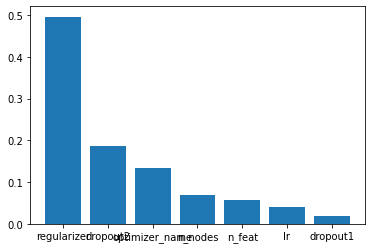

In [22]:
imp_dict=optuna.importance.get_param_importances(study)
keys=imp_dict.keys()
values=imp_dict.values()
plt.bar(keys, values)
plt.show()

In [23]:
print(study.best_trial.params)
param = study.best_trial.params

{'lr': 0.002848634785409013, 'dropout1': 0.0, 'dropout2': 0.05, 'optimizer_name': 'Adam', 'n_feat': 10, 'regularizer': 0.0, 'n_nodes': 500}


### best model from optuna

In [10]:
best_net_random_search = {'lr': 0.002848634785409013, 'dropout1': 0.0, 'dropout2': 0.05, 'optimizer_name': 'Adam', 'n_feat': 10, 'regularizer': 0.0, 'n_nodes': 500}
# from random _ search 
param=best_net_random_search

End_epoch number : 1, train _loss is : 0.7327559590339661, val_loss is 0.44523510336875916
End_epoch number : 2, train _loss is : 0.40191712975502014, val_loss is 0.35545656085014343
End_epoch number : 3, train _loss is : 0.3341521620750427, val_loss is 0.29501816630363464
End_epoch number : 4, train _loss is : 0.29619961977005005, val_loss is 0.26914963126182556
End_epoch number : 5, train _loss is : 0.27309104800224304, val_loss is 0.2526758015155792
End_epoch number : 6, train _loss is : 0.2579959034919739, val_loss is 0.23056210577487946
End_epoch number : 7, train _loss is : 0.23941849172115326, val_loss is 0.21848084032535553
End_epoch number : 8, train _loss is : 0.22107185423374176, val_loss is 0.1937054991722107
End_epoch number : 9, train _loss is : 0.21099239587783813, val_loss is 0.18119867146015167
INFO: Early stopping counter 1 of 4
End_epoch number : 10, train _loss is : 0.196156844496727, val_loss is 0.18702523410320282
End_epoch number : 11, train _loss is : 0.19055813

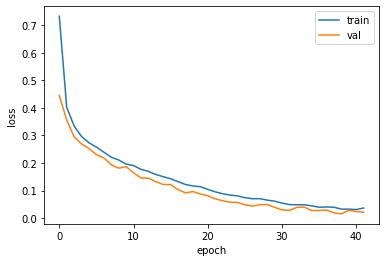

In [105]:
# Define the loss function
loss_fn = nn.CrossEntropyLoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_model = CNN2d(n_feat=param['n_feat'], dp1D=param['dropout1'],dp2D=param['dropout2'], Nf = param['n_nodes']).to(device)

# Initialization of the optimizer
if param['optimizer_name']=='Adam':
    optimizer = optim.Adam(best_model.parameters(), lr=param['lr'],weight_decay= param['regularizer'])
elif param['optimizer_name']=='sgd':
    optimizer = optim.SGD(best_model.parameters(), momentum=0.9, lr=param['lr'], weight_decay= param['regularizer'] )

pp={'num_epochs' : 100,
    'device' : device,
    'patience' : 4}

train_loader = DataLoader(train_dataset, batch_size=1000, shuffle=True,)             #change train- test dataset
val_loader = DataLoader(valid_dataset, batch_size=1000,shuffle=False)

train_loss, val_loss = best_model.fit(train_loader, val_loader, optimizer, loss_fn,pp)

plt.plot(train_loss, label='train')
plt.plot(val_loss, label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [107]:
test_loader = DataLoader(test_dataset, batch_size=1,shuffle=False)
test_loss , test_acc = best_model.test(test_loader, device, loss_fn)

print(f"Test loss :{test_loss}, Test Accuracy: {test_acc*100.0}% ")

Test loss :0.4852016568183899, Test Accuracy: 91.17999999999999% 


In [108]:
def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

test_loader = DataLoader(test_dataset, batch_size=100,shuffle=False)
class_correct = [0. for _ in range(10)]
total_correct = [0. for _ in range(10)]

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        test = torch.autograd.Variable(images)
        outputs = best_model(test)
        predicted = torch.max(outputs, 1)[1]
        c = (predicted == labels).squeeze()
        
        for i in range(100):
            label = labels[i]
            class_correct[label] += c[i].item()
            total_correct[label] += 1
        
for i in range(10):
    print("Accuracy of {}: {:.2f}%".format(output_label(i), class_correct[i] * 100 / total_correct[i]))

Accuracy of T-shirt/Top: 91.50%
Accuracy of Trouser: 98.00%
Accuracy of Pullover: 89.80%
Accuracy of Dress: 87.00%
Accuracy of Coat: 89.20%
Accuracy of Sandal: 98.50%
Accuracy of Shirt: 66.90%
Accuracy of Sneaker: 96.30%
Accuracy of Bag: 97.70%
Accuracy of Ankle Boot: 96.90%


# See weights, aka kernel filters

In [26]:
weights_CV1 = best_model.conv1.weight.data.cpu().numpy()
weights_CV2 = best_model.conv2.weight.data.cpu().numpy()

print(weights_CV1.shape) # 3x3 kernel , 6 feature map 1 input channel
print(weights_CV2.shape) # 5x5 kernel , 12 feature map 6 input channel


(10, 1, 3, 3)
(20, 10, 5, 5)


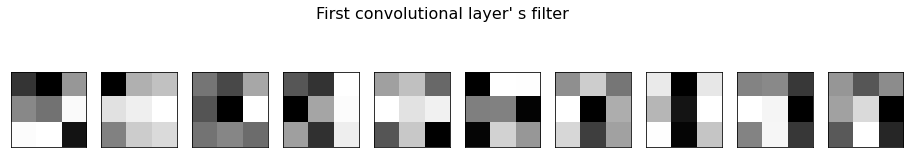

In [27]:
f1=int(param['n_feat'])

fig, ax = plt.subplots(1,f1, figsize=(16, 3))

for i in range(f1):
    ax[i].imshow( weights_CV1[i, 0, :, :], cmap='Greys')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
fig.suptitle("First convolutional layer' s filter", fontsize=16)

plt.show()

Text(0.5, 0.98, "Second convolutional layer's filter")

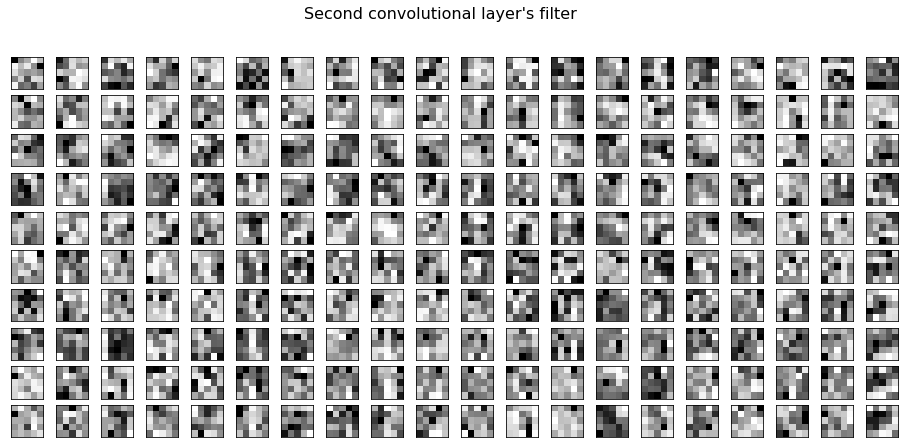

In [28]:
fig, ax = plt.subplots(f1, 2*f1, figsize=(16, 7) )

for i in range(f1):
    for j in range(2*f1):
        ax[i,j].imshow( weights_CV2[j, i, :,:], cmap='Greys')
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        
fig.suptitle("Second convolutional layer's filter", fontsize=16)

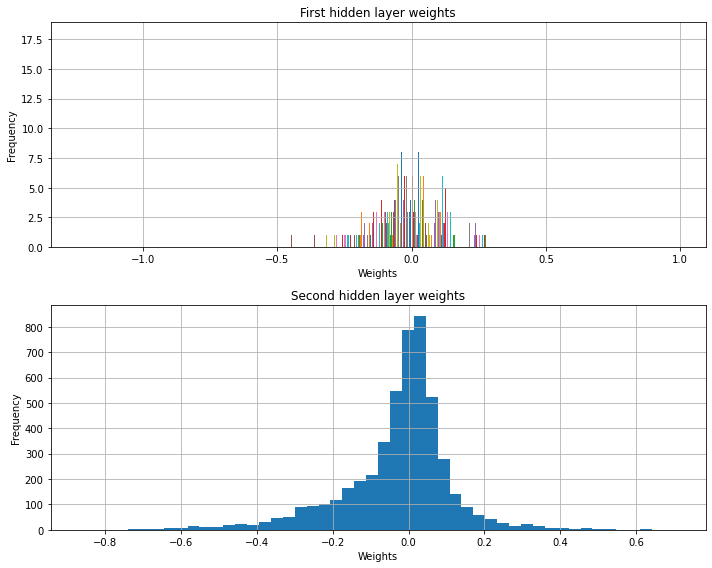

In [29]:
h1_w = best_model.fc1.weight.detach().cpu().numpy()
h2_w = best_model.fc2.weight.detach().cpu().numpy()

# Weights histogram
fig, axs = plt.subplots(2, 1, figsize=(10,8))

axs[0].hist(h1_w, 1000)
axs[0].set_title('First hidden layer weights')
axs[0].set_ylabel('Frequency')
axs[0].set_xlabel('Weights')
axs[1].hist(h2_w.flatten(), 50)
axs[1].set_title('Second hidden layer weights')
axs[1].set_ylabel('Frequency')
axs[1].set_xlabel('Weights')

[ax.grid() for ax in axs]
plt.tight_layout()
plt.show()


# Activation profiles 

In [30]:
def get_activation_conv1(layer, input, output):
    global activation_c1
    activation_c1 = F.relu(output)

def get_activation_conv2(layer, input, output):
    global activation_c2
    activation_c2 = F.relu(output)
   


image_load = DataLoader(test_dataset, batch_size=1, shuffle=False) 

### Register hook  
hook_handle = best_model.conv1.register_forward_hook(get_activation_conv1)
hook_handle2 = best_model.conv2.register_forward_hook(get_activation_conv2)

### Analyze activations
#net = best_model.to(device)
best_model.eval()

with torch.no_grad():
    for s_batch in image_load:
        # Move data to device
        x1 = s_batch[0].to(device)
        # Forward pass
        y1 = best_model(x1)
        z1 = activation_c1
        z2 = activation_c2


### Remove hook
hook_handle.remove()
hook_handle2.remove()

act1 = z1.cpu().numpy()
act2 = z2.cpu().numpy()
print(act1.shape, act2.shape)



(1, 10, 28, 28) (1, 20, 10, 10)


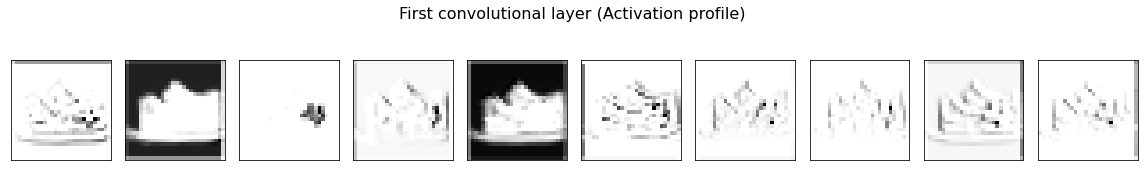

In [31]:
## Plot activations conv_1
fig, ax = plt.subplots(1, f1, figsize=(16,3))
for i in range(f1):
    ax[i].imshow( act1[0, i, :, :], cmap='Greys')
    ax[i].set_xticks([])
    ax[i].set_yticks([])

fig.suptitle('First convolutional layer (Activation profile)', fontsize=16)    
plt.tight_layout()
plt.show()   


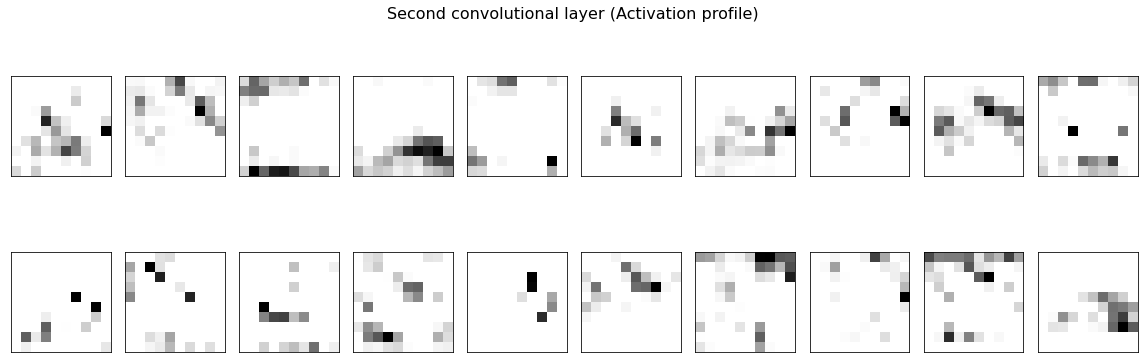

In [32]:
## Plot activations conv_2
fig, ax = plt.subplots(2, f1, figsize=(16,6))
for i in range(f1):
    ax[0,i].imshow( act2[0, i, :, :], cmap='Greys')
    ax[0,i].set_xticks([])
    ax[0,i].set_yticks([])
    ax[1,i].imshow( act2[0, i+f1, :, :], cmap='Greys')
    ax[1,i].set_xticks([])
    ax[1,i].set_yticks([])


fig.suptitle('Second convolutional layer (Activation profile)', fontsize=16)    
plt.tight_layout()
plt.show() 